# Survivability on Titanic

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import ml_utils.utils as utils

# pandas configuration
pd.options.display.max_rows = None
pd.options.display.max_columns = None

# seaborn configuration
sns.set_theme(
    palette='bright',
    rc={"axes.facecolor": "#f7e1d7", "figure.facecolor": "#f5f5f5"}
)

## Dataset

We got the dataset from OpenML for a complete reference instead of the Kaggle one. But it's in ARFF format, so we need to convert it to pandas' DataFrame and eventually CSV.

In [2]:
import arff

with open('input/titanic.arff', 'r') as f:
    dataset = arff.load(f)

columns = [attr[0] for attr in dataset['attributes']]
df = pd.DataFrame(dataset['data'], columns=columns)
print(df.shape)
display(df.sample(5, random_state=23))

(1309, 14)


,pclass,survived,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,boat,body,home.dest
768,3.0,0,"Denkoff, Mr. Mitto",male,NaN,0.0,0.0,349225,7.8958,None,S,None,NaN,"Bulgaria Coon Rapids, IA"
593,2.0,1,"West, Mrs. Edwy Arthur (Ada Mary Worth)",female,33.0,1.0,2.0,C.A. 34651,27.7500,None,S,10,NaN,"Bournmouth, England"
1157,3.0,0,"Rosblom, Mr. Viktor Richard",male,18.0,1.0,1.0,370129,20.2125,None,S,None,NaN,None
847,3.0,0,"Hanna, Mr. Mansour",male,23.5,0.0,0.0,2693,7.2292,None,C,None,188.0,None
686,3.0,1,"Bradley, Miss. Bridget Delia",female,22.0,0.0,0.0,334914,7.7250,None,Q,13,NaN,"Kingwilliamstown, Co Cork, Ireland Glens Falls..."


Two issues from this result:

1. It contains data leakage when our target is to predict survivability. Both `boat` and `body` values indicate whether certain passengers survived or not.
2. The target column, `survived`, is not on the right position.

Let's solve the problems.

In [3]:
df = df.drop(columns=['boat', 'body'])

In [4]:
cols = [col for col in df.columns if col != 'survived'] + ['survived']
df = df[cols]

We would also like to reshuffle the rows to avoid mimicking the existing Titanic dataset.

In [5]:
print('Before reshuffle')
display(df.sample(5, random_state=29))
df = df.sample(frac=1, random_state=23).reset_index(drop=True)
print('After reshuffle')
display(df.sample(5, random_state=29))

Before reshuffle


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived
1288,3.0,"Wiklund, Mr. Jakob Alfred",male,18.0,1.0,0.0,3101267,6.4958,None,S,None,0
169,1.0,"Isham, Miss. Ann Elizabeth",female,50.0,0.0,0.0,PC 17595,28.7125,C49,C,"Paris, France New York, NY",0
954,3.0,"Lefebre, Master. Henry Forbes",male,NaN,3.0,1.0,4133,25.4667,None,S,None,0
623,3.0,"Andersson, Miss. Ebba Iris Alfrida",female,6.0,4.0,2.0,347082,31.2750,None,S,"Sweden Winnipeg, MN",0
917,3.0,"Karun, Mr. Franz",male,39.0,0.0,1.0,349256,13.4167,None,C,None,1


After reshuffle


,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived
1288,2.0,"Walcroft, Miss. Nellie",female,31.0,0.0,0.0,F.C.C. 13528,21.0000,None,S,"Mamaroneck, NY",1
169,3.0,"Peter, Master. Michael J",male,NaN,1.0,1.0,2668,22.3583,None,C,None,1
954,3.0,"Danoff, Mr. Yoto",male,27.0,0.0,0.0,349219,7.8958,None,S,"Bulgaria Chicago, IL",0
623,1.0,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1.0,0.0,113803,53.1000,C123,S,"Scituate, MA",1
917,3.0,"Bourke, Miss. Mary",female,NaN,0.0,2.0,364848,7.7500,None,Q,"Ireland Chicago, IL",0


Now let's store the newest dataframe to CSV.

In [6]:
df.to_csv('input/titanic.csv', index=False)

## Exploration

### EDA

#### Dataset Imbalance

Calculate the dataset's imbalance ratio:

In [94]:
survived_counts = df['survived'].value_counts()
imbalance_ratio = survived_counts.max() / survived_counts.min()
print(f"Imbalance Ratio = {imbalance_ratio:.2f}:1")

Imbalance Ratio = 1.62:1


Separate the dataset into train and test sets for the sake of exploration.

In [95]:
from sklearn.model_selection import train_test_split

X = df.drop(columns=['survived'])
y = df['survived']

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=29,
    stratify=y
)

In [96]:
utils.skim_data(X_train)

Total duplicate rows: 0
DF shape: (1047, 11)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,pclass,float64,0.000,0.0,0.0,3,0.29,"[3.0, 1.0, 2.0]"
1,name,object,0.000,-,-,1046,99.90,"[Olsen, Mr. Karl Siegwart Andreas, Stengel, Mr..."
2,sex,object,0.000,-,-,2,0.19,"[male, female]"
3,age,float64,20.439,0.0,0.0,95,9.07,"[42.0, 54.0, 51.0, 38.0, 22.0]"
4,sibsp,float64,0.000,0.0,67.622,7,0.67,"[0.0, 1.0, 4.0, 3.0, 2.0]"
5,parch,float64,0.000,0.0,76.313,8,0.76,"[1.0, 0.0, 2.0, 6.0, 5.0]"
6,ticket,object,0.000,-,-,775,74.02,"[4579, 11778, 113055, 315089, 248738]"
7,fare,float64,0.096,0.0,1.242,265,25.31,"[8.4042, 55.4417, 26.55, 8.6625, 29.0]"
8,cabin,object,77.077,-,-,160,15.28,"[C116, E17, G6, B37, C2]"
9,embarked,object,0.096,-,-,3,0.29,"[S, C, Q]"


In [97]:
utils.skim_data(X_test)

Total duplicate rows: 0
DF shape: (262, 11)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,pclass,float64,0.000,0.0,0.0,3,1.15,"[1.0, 2.0, 3.0]"
1,name,object,0.000,-,-,261,99.62,"[Kreuchen, Miss. Emilie, Reynaldo, Ms. Encarna..."
2,sex,object,0.000,-,-,2,0.76,"[female, male]"
3,age,float64,18.702,0.0,0.0,64,24.43,"[39.0, 28.0, 18.0, 32.0, 42.0]"
4,sibsp,float64,0.000,0.0,69.847,6,2.29,"[0.0, 1.0, 8.0, 3.0, 4.0]"
5,parch,float64,0.000,0.0,77.481,6,2.29,"[0.0, 2.0, 1.0, 5.0, 4.0]"
6,ticket,object,0.000,-,-,237,90.46,"[24160, 230434, A./5. 3235, 315091, 13214]"
7,fare,float64,0.000,0.0,1.527,132,50.38,"[211.3375, 13.0, 8.05, 8.6625, 30.5]"
8,cabin,object,79.008,-,-,50,19.08,"[B50, E63, A34, B28, B57 B59 B63 B66]"
9,embarked,object,0.382,-,-,3,1.15,"[S, C, Q]"


In [98]:
df_train = pd.concat([X_train, y_train], axis=1)

In [99]:
df_test = pd.concat([X_test, y_test], axis=1)

#### Cabin

In [100]:
df_temp = df_train.copy()
df_temp['cabin_initial'] = df_temp['cabin'].str[0]
df_temp['cabin_initial'] = df_temp['cabin_initial'].fillna('M')
utils.skim_data(df_temp)

Total duplicate rows: 0
DF shape: (1047, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,pclass,float64,0.000,0.0,0.0,3,0.29,"[3.0, 1.0, 2.0]"
1,name,object,0.000,-,-,1046,99.90,"[Olsen, Mr. Karl Siegwart Andreas, Stengel, Mr..."
2,sex,object,0.000,-,-,2,0.19,"[male, female]"
3,age,float64,20.439,0.0,0.0,95,9.07,"[42.0, 54.0, 51.0, 38.0, 22.0]"
4,sibsp,float64,0.000,0.0,67.622,7,0.67,"[0.0, 1.0, 4.0, 3.0, 2.0]"
5,parch,float64,0.000,0.0,76.313,8,0.76,"[1.0, 0.0, 2.0, 6.0, 5.0]"
6,ticket,object,0.000,-,-,775,74.02,"[4579, 11778, 113055, 315089, 248738]"
7,fare,float64,0.096,0.0,1.242,265,25.31,"[8.4042, 55.4417, 26.55, 8.6625, 29.0]"
8,cabin,object,77.077,-,-,160,15.28,"[C116, E17, G6, B37, C2]"
9,embarked,object,0.096,-,-,3,0.29,"[S, C, Q]"


In [101]:
cabin_order = sorted(df_temp['cabin_initial'].unique())
cabin_order

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M', 'T']

In [102]:
df_temp.loc[df_temp['cabin_initial'] == 'T']

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,cabin_initial
718,1.0,"Blackwell, Mr. Stephen Weart",male,45.0,0.0,0.0,113784,35.5,T,S,"Trenton, NJ",0,T


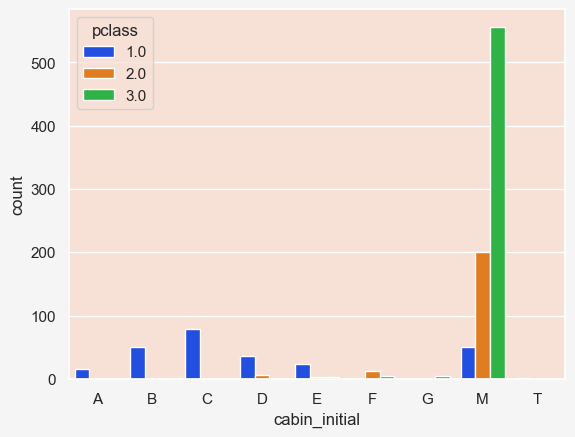

In [103]:
sns.countplot(x='cabin_initial', hue='pclass', data=df_temp, order=cabin_order, palette='bright')
plt.show()

In [104]:
df_temp.loc[df_temp['cabin_initial'] == 'T', 'cabin_initial'] = 'A'

In [105]:
cabin_order = sorted(df_temp['cabin_initial'].unique())
cabin_order

['A', 'B', 'C', 'D', 'E', 'F', 'G', 'M']

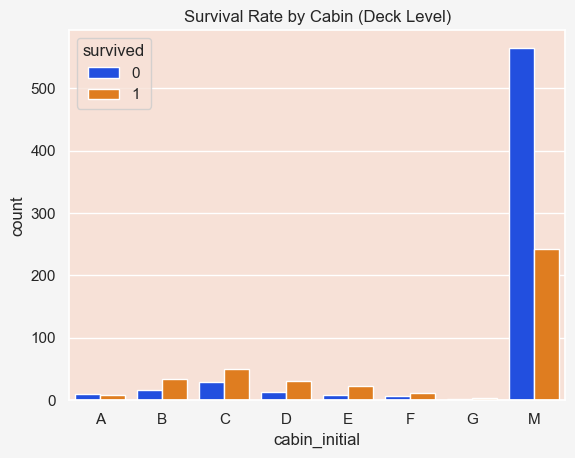

In [106]:
sns.countplot(x='cabin_initial', hue='survived', data=df_temp, order=cabin_order)
plt.title('Survival Rate by Cabin (Deck Level)')
plt.show()

In [107]:
df_temp['cabin_initial'] = (
    df_temp['cabin_initial']
    .replace(['A', 'B', 'C'], 'ABC')
    .replace(['D', 'E', 'F', 'G'], 'DEFG')
)
utils.skim_data(df_temp)

Total duplicate rows: 0
DF shape: (1047, 13)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,pclass,float64,0.000,0.0,0.0,3,0.29,"[3.0, 1.0, 2.0]"
1,name,object,0.000,-,-,1046,99.90,"[Olsen, Mr. Karl Siegwart Andreas, Stengel, Mr..."
2,sex,object,0.000,-,-,2,0.19,"[male, female]"
3,age,float64,20.439,0.0,0.0,95,9.07,"[42.0, 54.0, 51.0, 38.0, 22.0]"
4,sibsp,float64,0.000,0.0,67.622,7,0.67,"[0.0, 1.0, 4.0, 3.0, 2.0]"
5,parch,float64,0.000,0.0,76.313,8,0.76,"[1.0, 0.0, 2.0, 6.0, 5.0]"
6,ticket,object,0.000,-,-,775,74.02,"[4579, 11778, 113055, 315089, 248738]"
7,fare,float64,0.096,0.0,1.242,265,25.31,"[8.4042, 55.4417, 26.55, 8.6625, 29.0]"
8,cabin,object,77.077,-,-,160,15.28,"[C116, E17, G6, B37, C2]"
9,embarked,object,0.096,-,-,3,0.29,"[S, C, Q]"


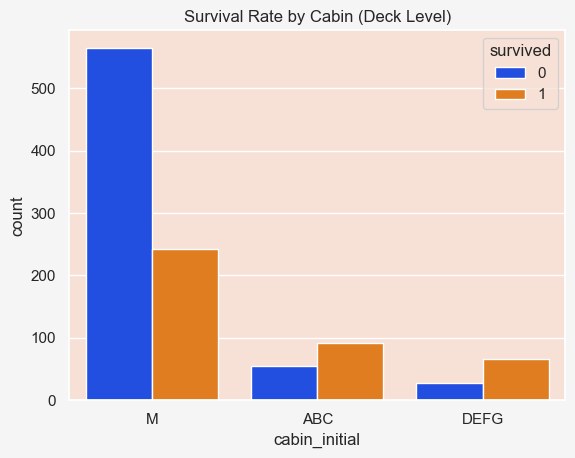

In [108]:
sns.countplot(x='cabin_initial', hue='survived', data=df_temp)
plt.title('Survival Rate by Cabin (Deck Level)')
plt.show()

In [109]:
df_temp['has_cabin'] = (df_temp['cabin_initial'] != 'M') * 1
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,cabin_initial,has_cabin
1133,3.0,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0.0,1.0,4579,8.4042,None,S,None,0,M,0
414,1.0,"Stengel, Mr. Charles Emil Henry",male,54.0,1.0,0.0,11778,55.4417,C116,C,"Newark, NJ",1,ABC,1
469,1.0,"Daly, Mr. Peter Denis",male,51.0,0.0,0.0,113055,26.5500,E17,S,"Lima, Peru",1,DEFG,1
1190,3.0,"Cacic, Mr. Luka",male,38.0,0.0,0.0,315089,8.6625,None,S,Croatia,0,M,0
583,2.0,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1.0,1.0,248738,29.0000,None,S,"Bangkok, Thailand / Roseville, IL",1,M,0


<Axes: xlabel='has_cabin', ylabel='count'>

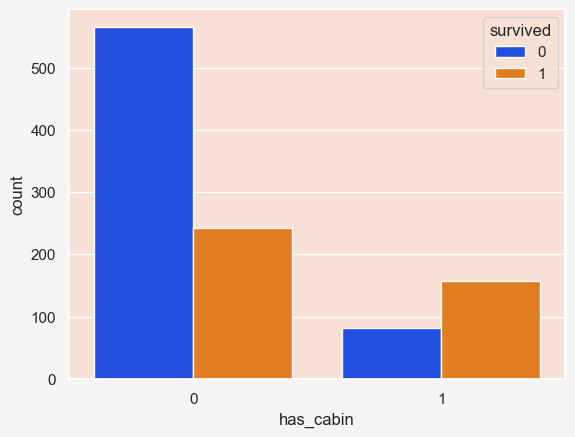

In [110]:
sns.countplot(data=df_temp, x='has_cabin', hue='survived')

#### Name

In [111]:
df_temp = df_train.copy()
df_temp['title'] = (
    df_temp['name']
    .str.extract(r' ([A-Za-z]+)\.', expand=False)
)
display(utils.skim_data(df_temp[['name', 'title']]))
display(df_temp[['name', 'title']].head())

Total duplicate rows: 1
DF shape: (1047, 2)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,name,object,0.0,-,-,1046,99.90,"[Olsen, Mr. Karl Siegwart Andreas, Stengel, Mr..."
1,title,object,0.0,-,-,16,1.53,"[Mr, Mrs, Master, Miss, Dr]"


,name,title
1133,"Olsen, Mr. Karl Siegwart Andreas",Mr
414,"Stengel, Mr. Charles Emil Henry",Mr
469,"Daly, Mr. Peter Denis",Mr
1190,"Cacic, Mr. Luka",Mr
583,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",Mrs


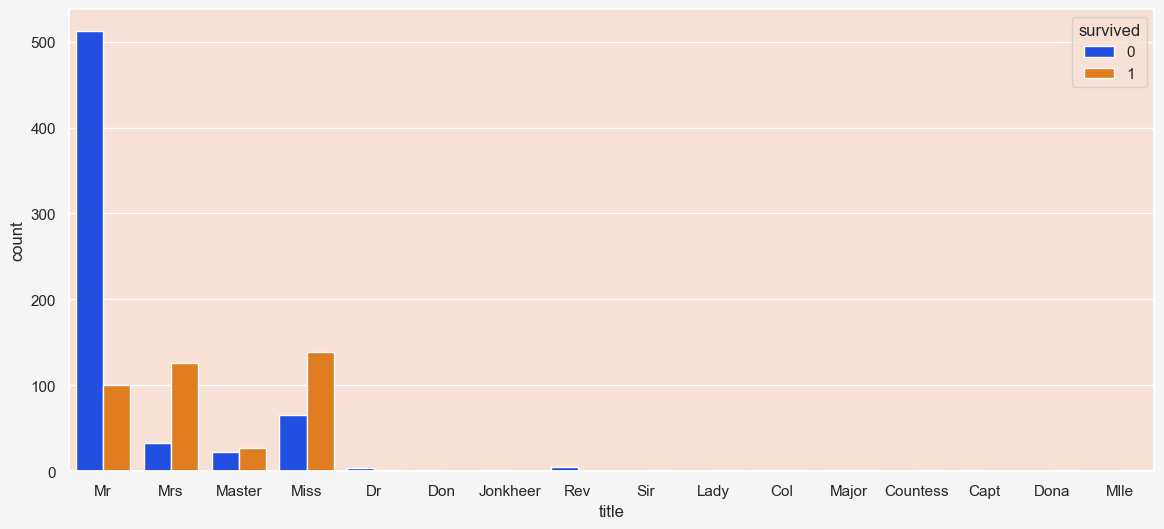

In [112]:
plt.figure(figsize=(14, 6))
sns.countplot(data=df_temp, x='title', hue='survived')
plt.show()

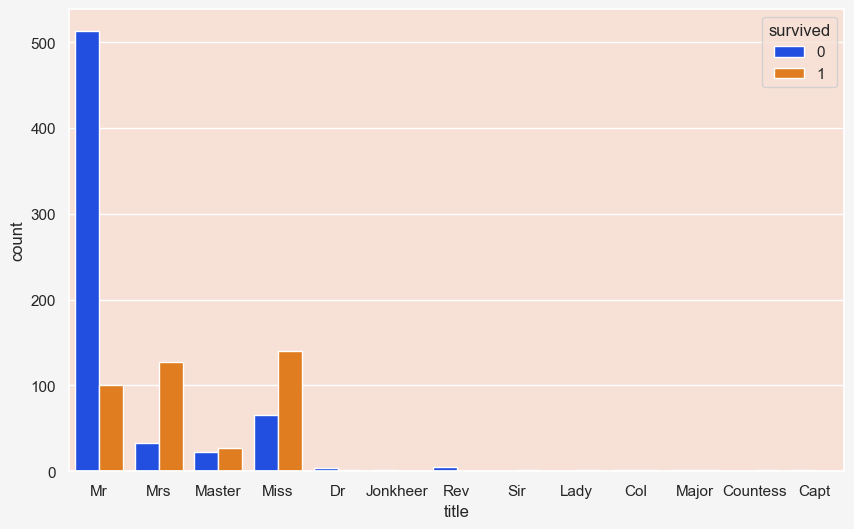

In [113]:
df_temp['title'] = (
    df_temp['title']
    .replace('Don', 'Mr')
    .replace('Dona', 'Mrs')
    .replace('Mlle', 'Miss')
)
plt.figure(figsize=(10, 6))
sns.countplot(data=df_temp, x='title', hue='survived')
plt.show()

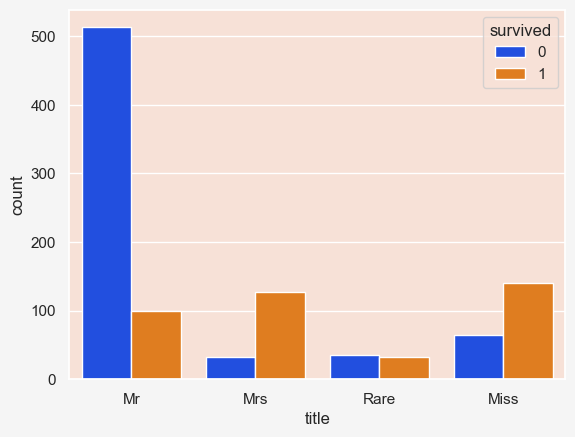

In [114]:
df_temp['title'] = (
    df_temp['title']
    .replace(['Dr', 'Jonkheer', 'Rev', 'Sir', 'Lady', 'Col', 'Major', 'Countess', 'Capt', 'Master'], 'Rare')
)
sns.countplot(data=df_temp, x='title', hue='survived')
plt.show()

#### Age

##### Global Median

28.0


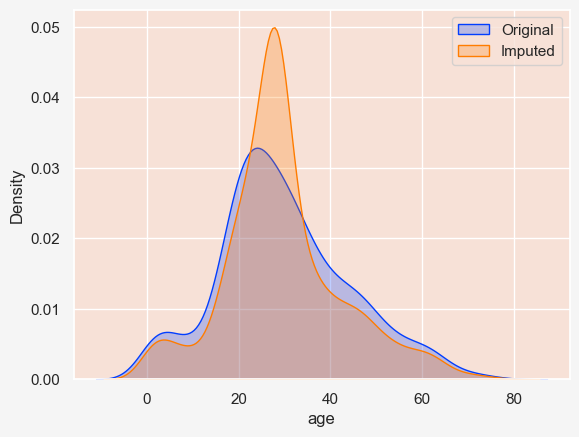

In [115]:
df_temp = df_train.copy()
global_median = df_temp['age'].median()
print(global_median)
df_temp['age'] = df_temp['age'].fillna(global_median)
sns.kdeplot(df_train['age'], label='Original', fill=True)
sns.kdeplot(df_temp['age'], label='Imputed', fill=True)
plt.legend()

##### Median by `pclass`

pclass
1.0    38.0
2.0    28.0
3.0    24.0
Name: age, dtype: float64

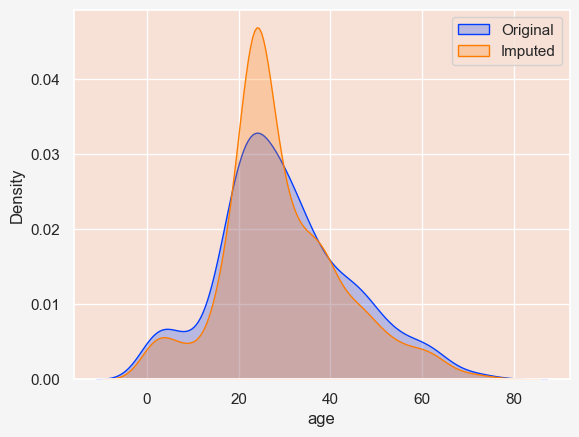

In [116]:
df_temp = df_train.copy()
display(df_temp.groupby('pclass')['age'].median())
pclass_median = df_temp.groupby('pclass')['age'].transform('median')
df_temp['age'] = df_temp['age'].fillna(pclass_median)
sns.kdeplot(df_train['age'], label='Original', fill=True)
sns.kdeplot(df_temp['age'], label='Imputed', fill=True)
plt.legend()

##### Median by `pclass` and `age`

pclass  sex   
1.0     female    35.0
        male      40.5
2.0     female    27.0
        male      29.0
3.0     female    22.0
        male      25.0
Name: age, dtype: float64

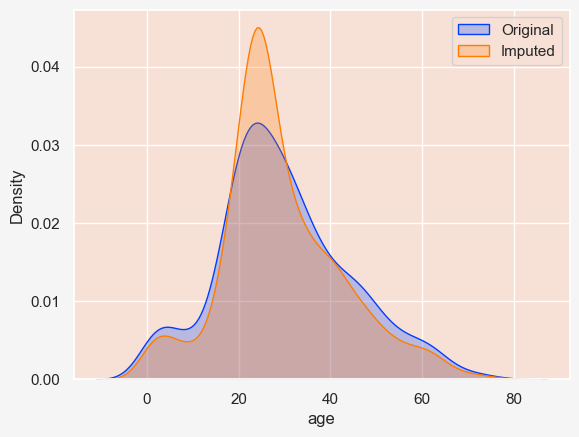

In [117]:
df_temp = df_train.copy()
display(df_temp.groupby(['pclass', 'sex'])['age'].median())
pclass_sex_median = df_temp.groupby(['pclass', 'sex'])['age'].transform('median')
df_temp['age'] = df_temp['age'].fillna(pclass_sex_median)
sns.kdeplot(df_train['age'], label='Original', fill=True)
sns.kdeplot(df_temp['age'], label='Imputed', fill=True)
plt.legend()

#### Fare

In [118]:
df_temp = df_train.copy()

In [119]:
print(f'Fare mean: {df_train['fare'].mean()}, Fare median: {df_train['fare'].median()}')

Fare mean: 33.222677437858515, Fare median: 14.5


There is a correlation between `ticket` and `fare`.

In [120]:
df_temp['ticket'].value_counts()

ticket
CA. 2343              10
CA 2144                8
1601                   7
113781                 6
3101295                6
113503                 5
PC 17608               5
347082                 5
S.O.C. 14879           5
347088                 5
347077                 5
4133                   4
C.A. 33112             4
PC 17757               4
C.A. 2315              4
19950                  4
230136                 4
PC 17755               4
16966                  4
W./C. 6608             4
248727                 3
PC 17569               3
2678                   3
2661                   3
C.A. 34651             3
26360                  3
2653                   3
28220                  3
2666                   3
19877                  3
315153                 3
347080                 3
C.A. 31029             3
SC/Paris 2123          3
113760                 3
C 4001                 3
13502                  3
239853                 3
PC 17582               3
C.A. 2673         

In [121]:
df_temp[df_temp['ticket'] == 'CA. 2343']

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived
661,3.0,"Sage, Mr. Frederick",male,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
984,3.0,"Sage, Mrs. John (Annie Bullen)",female,NaN,1.0,9.0,CA. 2343,69.55,None,S,None,0
410,3.0,"Sage, Miss. Ada",female,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
923,3.0,"Sage, Mr. George John Jr",male,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
703,3.0,"Sage, Miss. Dorothy Edith 'Dolly'",female,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
93,3.0,"Sage, Mr. Douglas Bullen",male,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
301,3.0,"Sage, Miss. Stella Anna",female,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
1021,3.0,"Sage, Mr. John George",male,NaN,1.0,9.0,CA. 2343,69.55,None,S,None,0
1145,3.0,"Sage, Master. Thomas Henry",male,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0
717,3.0,"Sage, Miss. Constance Gladys",female,NaN,8.0,2.0,CA. 2343,69.55,None,S,None,0


In [122]:
df_temp['people_in_ticket'] = df_temp['ticket'].map(df_temp['ticket'].value_counts())
df_temp['people_in_ticket'] = df_temp['people_in_ticket'].fillna(1)
df_temp['fare_per_person'] = df_temp['fare'] / df_temp['people_in_ticket']

In [123]:
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,people_in_ticket,fare_per_person
1133,3.0,"Olsen, Mr. Karl Siegwart Andreas",male,42.0,0.0,1.0,4579,8.4042,None,S,None,0,1,8.404200
414,1.0,"Stengel, Mr. Charles Emil Henry",male,54.0,1.0,0.0,11778,55.4417,C116,C,"Newark, NJ",1,2,27.720850
469,1.0,"Daly, Mr. Peter Denis",male,51.0,0.0,0.0,113055,26.5500,E17,S,"Lima, Peru",1,1,26.550000
1190,3.0,"Cacic, Mr. Luka",male,38.0,0.0,0.0,315089,8.6625,None,S,Croatia,0,1,8.662500
583,2.0,"Caldwell, Mrs. Albert Francis (Sylvia Mae Harb...",female,22.0,1.0,1.0,248738,29.0000,None,S,"Bangkok, Thailand / Roseville, IL",1,3,9.666667


In [124]:
df_temp[df_temp['fare_per_person'].isna()]

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,people_in_ticket,fare_per_person
788,3.0,"Storey, Mr. Thomas",male,60.5,0.0,0.0,3701,NaN,None,S,None,0,1,NaN


In [125]:
df_temp.groupby('pclass')['fare_per_person'].agg(['mean', 'median'])

,mean,median
pclass,,
1.0,38.696463,31.166667
2.0,12.589385,13.000000
3.0,7.743551,7.775000


In [126]:
df_temp.groupby(['pclass', 'sex'])['fare_per_person'].agg(['mean', 'median'])

mean   median
pclass sex                       
1.0    female  43.838958  36.3000
       male    34.751535  30.5000
2.0    female  12.874132  13.0000
       male    12.414795  13.0000
3.0    female   7.626133   7.7500
       male     7.794255   7.7958

<Axes: xlabel='fare_per_person', ylabel='Density'>

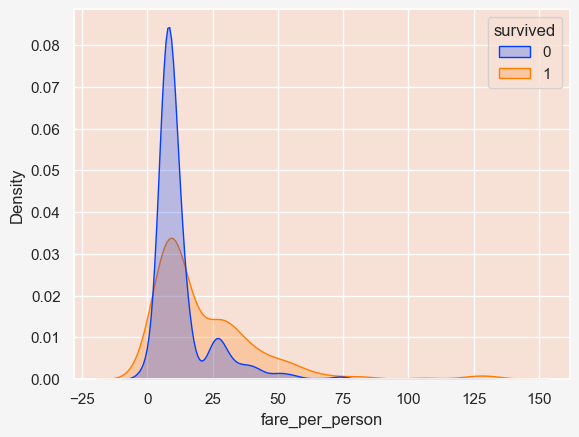

In [127]:
sns.kdeplot(data=df_temp, x='fare_per_person', hue='survived', fill=True, common_norm=False)

In [128]:
df_train[df_train['fare'] == 0]

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived
921,1.0,"Fry, Mr. Richard",male,NaN,0.0,0.0,112058,0.0,B102,S,None,0
605,1.0,"Reuchlin, Jonkheer. John George",male,38.0,0.0,0.0,19972,0.0,None,S,"Rotterdam, Netherlands",0
670,3.0,"Tornquist, Mr. William Henry",male,25.0,0.0,0.0,LINE,0.0,None,S,None,1
1191,1.0,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0.0,0.0,112051,0.0,None,S,"Liverpool, England / Belfast",0
1253,1.0,"Harrison, Mr. William",male,40.0,0.0,0.0,112059,0.0,B94,S,None,0
38,2.0,"Frost, Mr. Anthony Wood 'Archie'",male,NaN,0.0,0.0,239854,0.0,None,S,Belfast,0
909,2.0,"Watson, Mr. Ennis Hastings",male,NaN,0.0,0.0,239856,0.0,None,S,Belfast,0
1215,1.0,"Andrews, Mr. Thomas Jr",male,39.0,0.0,0.0,112050,0.0,A36,S,"Belfast, NI",0
109,2.0,"Campbell, Mr. William",male,NaN,0.0,0.0,239853,0.0,None,S,Belfast,0
535,3.0,"Leonard, Mr. Lionel",male,36.0,0.0,0.0,LINE,0.0,None,S,None,0


In [129]:
df_temp[df_temp['fare_per_person'] == 0]

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,people_in_ticket,fare_per_person
921,1.0,"Fry, Mr. Richard",male,NaN,0.0,0.0,112058,0.0,B102,S,None,0,1,0.0
605,1.0,"Reuchlin, Jonkheer. John George",male,38.0,0.0,0.0,19972,0.0,None,S,"Rotterdam, Netherlands",0,1,0.0
670,3.0,"Tornquist, Mr. William Henry",male,25.0,0.0,0.0,LINE,0.0,None,S,None,1,2,0.0
1191,1.0,"Chisholm, Mr. Roderick Robert Crispin",male,NaN,0.0,0.0,112051,0.0,None,S,"Liverpool, England / Belfast",0,1,0.0
1253,1.0,"Harrison, Mr. William",male,40.0,0.0,0.0,112059,0.0,B94,S,None,0,1,0.0
38,2.0,"Frost, Mr. Anthony Wood 'Archie'",male,NaN,0.0,0.0,239854,0.0,None,S,Belfast,0,1,0.0
909,2.0,"Watson, Mr. Ennis Hastings",male,NaN,0.0,0.0,239856,0.0,None,S,Belfast,0,1,0.0
1215,1.0,"Andrews, Mr. Thomas Jr",male,39.0,0.0,0.0,112050,0.0,A36,S,"Belfast, NI",0,1,0.0
109,2.0,"Campbell, Mr. William",male,NaN,0.0,0.0,239853,0.0,None,S,Belfast,0,3,0.0
535,3.0,"Leonard, Mr. Lionel",male,36.0,0.0,0.0,LINE,0.0,None,S,None,0,2,0.0


In [130]:
# map fare against pclass and cabin

def apply_cabin_feature(df):
    df_copy = df.copy()
    df_copy['cabin'] = df_copy['cabin'].fillna('M')
    df_copy['cabin'] = df_copy['cabin'].str[0]
    df_copy.loc[df_copy['cabin'] == 'T', 'cabin'] = 'A'
    df_copy['cabin'] = (
        df_copy['cabin']
        .replace(['A', 'B', 'C'], 'ABC')
        .replace(['D', 'E', 'F', 'G'], 'DEFG')
    )
    df_copy['has_cabin'] = (df_copy['cabin'] != 'M') * 1
    return df_copy

df_temp = apply_cabin_feature(df_temp)
df_temp.groupby(['pclass', 'cabin'])['fare_per_person'].agg(['mean', 'median'])

mean   median
pclass cabin                    
1.0    ABC    42.892821  36.3000
       DEFG   31.177254  27.7208
       M      35.676923  27.7208
2.0    DEFG   11.544048  12.3500
       M      12.699145  13.0000
3.0    DEFG    7.428821   7.4396
       M       7.750356   7.7750

#### Family Size

In [131]:
df_temp = df_train.copy()
df_temp['family_size'] = df_train['parch'] + df_train['sibsp'] + 1

<Axes: xlabel='family_size', ylabel='count'>

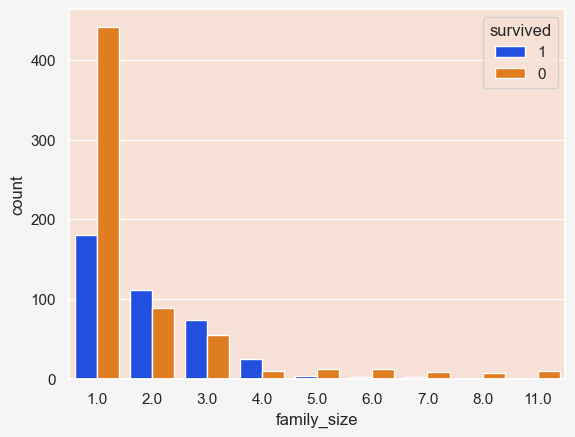

In [132]:
sns.countplot(data=df_temp, x='family_size', hue='survived')

In [133]:
bins = [0, 1, 4, 20]
labels = ['alone', 'middle', 'large']
df_temp['family_size'] = pd.cut(df_temp['family_size'], bins=bins, labels=labels)

<Axes: xlabel='family_size', ylabel='count'>

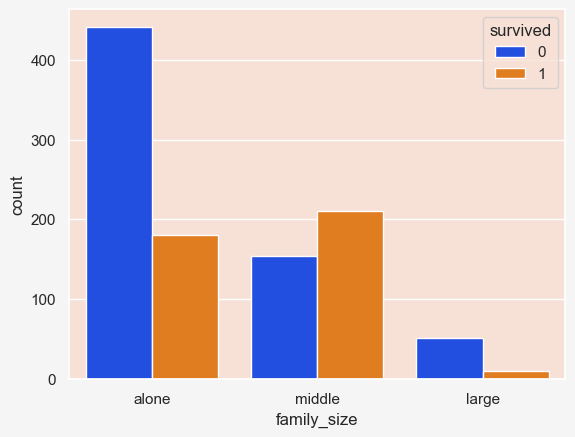

In [134]:
sns.countplot(data=df_temp, x='family_size', hue='survived')

#### EDA Conclusion

- Cabin:
    - Impute `cabin` with "M"
    - Convert "T" to "A"
    - Replace "A", "B", "C" with "ABC"
    - Replace "D", "E", "F", "G" with "DEFG"
    - Remove `cabin`
- Name:
    - Extract `title`
    - Replace "Don" with "Mr"
    - Replace "Dona" with "Mrs"
    - Replace "Mlle" with "Ms"
    - Replace ['Dr', 'Jonkheer', 'Rev', 'Sir', 'Lady', 'Col', 'Major', 'Countess', 'Capt', 'Master'] with "Rare"
    - Remove name
- Age:
    - Group `age` with `pclass` and `sex`
    - Impute missing values with its median
- Fare:
    - Find ticket_in_person
    - Find fare_per_person
    - Group findings based on pclass and sex
    - Impute missing values with its median
    - Remove initial ticket, fare, ticket_in_person
- Parch and SibSp
    - Combine with +1 as family_size
    - Create bin with alone, middle, large family size
    - Remove parch and sibsp
- Sex:
    - Convert to binary
- Embarked:
    - Impute with global mode
- Home.Dest:
    - Remove the feature

### Data Preprocessing

In [135]:
def remove_home_dest(df):
    df_copy = df.copy()
    return df_copy.drop('home.dest', axis=1)

In [136]:
def apply_cabin_feature(df):
    df_copy = df.copy()
    df_copy['cabin'] = df_copy['cabin'].fillna('M')
    df_copy['cabin'] = df_copy['cabin'].str[0]
    df_copy.loc[df_copy['cabin'] == 'T', 'cabin'] = 'A'
    df_copy['cabin'] = (
        df_copy['cabin']
        .replace(['A', 'B', 'C'], 'ABC')
        .replace(['D', 'E', 'F', 'G'], 'DEFG')
    )
    df_copy['has_cabin'] = (df_copy['cabin'] != 'M') * 1
    return df_copy

In [137]:
def apply_name_feature(df):
    df_temp = df.copy()
    df_temp['title'] = (
        df_temp['name']
        .str.extract(r' ([A-Za-z]+)\.', expand=False)
    )
    df_temp['title'] = (
        df_temp['title']
        .replace('Don', 'Mr')
        .replace('Dona', 'Mrs')
        .replace('Mlle', 'Ms')
        .replace('Mme', 'Mrs')
        .replace('Miss', 'Ms')
    )
    df_temp['title'] = (
        df_temp['title']
        .replace(
            [
                'Dr', 'Jonkheer', 'Rev', 'Sir', 'Lady',
                'Col', 'Major', 'Countess', 'Capt', 'Master'
            ],
            'Rare'
        )
    )
    return df_temp.drop('name', axis=1)

In [138]:
age_lookup = X_train.groupby(['pclass', 'sex'])['age'].median()

def apply_age_feature(df, lookup):
    df_temp = df.copy()
    median = df_temp.set_index(['pclass', 'sex']).index.map(lookup)
    df_temp['age'] = (
        df_temp['age']
        .fillna(
            pd.Series(median, index=df_temp.index)
        )
    )
    return df_temp

In [139]:
ticket_counts = X_train['ticket'].value_counts()
fare_lookup = X_train.groupby(['pclass', 'sex'])['fare'].median()

def apply_fare_feature(df, counts, lookup):
    df_copy = df.copy()
    median = df_copy.set_index(['pclass', 'sex']).index.map(lookup)
    df_copy['fare'] = (
        df_copy['fare'].fillna(
            pd.Series(median, index=df_copy.index)
        )
    )
    df_copy['people_in_ticket'] = df_copy['ticket'].map(counts)
    df_copy['people_in_ticket'] = df_copy['people_in_ticket'].fillna(1)
    df_copy['fare_per_person'] = df_copy['fare'] / df_copy['people_in_ticket']
    return df_copy.drop(columns=['people_in_ticket', 'ticket', 'fare'])

In [140]:
def apply_family_size_feature(df):
    df_temp = df.copy()
    df_temp['family_size'] = df['parch'] + df['sibsp'] + 1
    bins = [0, 1, 4, 20]
    labels = ['alone', 'middle', 'large']
    df_temp['family_size'] = pd.cut(
        df_temp['family_size'],
        bins=bins,
        labels=labels
    )
    return df_temp.drop(columns=['parch', 'sibsp'])

In [141]:
embarked_mode = X_train['embarked'].mode().get(0, 'S')

def apply_embarked_feature(df, mode):
    df_copy = df.copy()
    df_copy['embarked'] = df_copy['embarked'].fillna(mode)
    return df_copy

In [142]:
def apply_sex_feature(df):
    df_copy = df.copy()
    df_copy['sex'] = df_copy['sex'].map({'female': 0, 'male': 1})
    return df_copy

In [143]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder

transformer = ColumnTransformer(
    transformers=[
        (
            'encoder',
            OneHotEncoder(handle_unknown='ignore', sparse_output=False),
            ['cabin', 'embarked', 'family_size', 'title']
        ),
    ],
    remainder='passthrough',
    verbose_feature_names_out=False
)
transformer.set_output(transform='pandas')

def apply_ohe(df, transformer):
    return transformer.fit_transform(df)

In [144]:
def preprocessing(df):
    df_copy = df.copy()
    df_copy = remove_home_dest(df)
    df_copy = apply_age_feature(df_copy, age_lookup)
    df_copy = apply_cabin_feature(df_copy)
    df_copy = apply_family_size_feature(df_copy)
    df_copy = apply_name_feature(df_copy)
    df_copy = apply_fare_feature(df_copy, ticket_counts, fare_lookup)
    df_copy = apply_embarked_feature(df_copy, embarked_mode)
    df_copy = apply_sex_feature(df_copy)
    df_copy = apply_ohe(df_copy, transformer)
    return df_copy

In [145]:
X_train_processed = preprocessing(X_train)
X_train_processed.head()

,cabin_ABC,cabin_DEFG,cabin_M,embarked_C,embarked_Q,embarked_S,family_size_alone,family_size_large,family_size_middle,title_Mr,title_Mrs,title_Ms,title_Rare,pclass,sex,age,has_cabin,fare_per_person
1133,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,3.0,1,42.0,0,8.404200
414,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,54.0,1,27.720850
469,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,51.0,1,26.550000
1190,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1,38.0,0,8.662500
583,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0,0,22.0,0,9.666667


In [146]:
X_test_processed = preprocessing(X_test)
X_test_processed.head()

,cabin_ABC,cabin_DEFG,cabin_M,embarked_C,embarked_Q,embarked_S,family_size_alone,family_size_large,family_size_middle,title_Mr,title_Mrs,title_Ms,title_Rare,pclass,sex,age,has_cabin,fare_per_person
442,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,39.0,0,105.66875
891,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0,28.0,0,13.00000
497,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1,25.0,0,8.05000
1282,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,3.0,1,18.0,0,8.66250
412,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1,32.0,1,30.50000


### Modeling

In [147]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy='most_frequent', random_state=29)
dummy_clf.fit(X_train_processed, y_train)
dummy_acc = dummy_clf.score(X_test_processed, y_test)
print(f"Baseline (Most Frequent): {dummy_acc:.4f}")

Baseline (Most Frequent): 0.6183


In [148]:
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, HistGradientBoostingClassifier
from sklearn.metrics import accuracy_score

models = {
    "log_reg": LogisticRegression(solver='liblinear', max_iter=100_000, random_state=29),
    "dt": DecisionTreeClassifier(random_state=29),
    "hist_boost": HistGradientBoostingClassifier(random_state=29),
    "rf": RandomForestClassifier(max_depth=5, random_state=29)
}
base_result = []

for name, model in models.items():
    print(f'Now training {name}')
    model.fit(X_train_processed, y_train)
    y_pred_train = model.predict(X_train_processed)
    y_pred = model.predict(X_test_processed)
    train_acc = accuracy_score(y_train, y_pred_train)
    test_acc = accuracy_score(y_test, y_pred)
    base_result.append({
        'model': name,
        'train_score': train_acc,
        'test_score (No CV)': test_acc
    })

df_base_result = pd.DataFrame(base_result).set_index('model')
df_base_result

Now training log_reg
Now training dt
Now training hist_boost
Now training rf


,train_score,test_score (No CV)
model,,
log_reg,0.821394,0.805344
dt,0.974212,0.797710
hist_boost,0.940783,0.801527
rf,0.829990,0.820611


In [149]:
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV

param_grids = {
    "log_reg": {
        'C': [0.01, 0.1, 1, 10, 100], 
        'penalty': ['l1', 'l2'],
        'max_iter': [100000],
        'solver': ['liblinear']
    },
    "dt": {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "rf": {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    "hist_boost": {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 150],
        'max_depth': [3, 5],
        'l2_regularization': [0, 0.1, 1.0]
    }
}
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

for name, model in models.items():
    print(f"Tuning {name}...")
    cv_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grids[name], 
        cv=skf, 
        scoring='accuracy',
        random_state=29
    )
    cv_search.fit(X_train_processed, y_train)
    models[name] = cv_search.best_estimator_
    cv_results.append({
        'model': name,
        'best_cv_accuracy': cv_search.best_score_,
        'test_accuracy': cv_search.score(X_test_processed, y_test),
        'best_params': cv_search.best_params_
    })

df_results = (
    pd.DataFrame(cv_results)
    .set_index('model')
    .sort_values('test_accuracy', ascending=False)
)
print("\nFinal Results:")
df_results

Tuning log_reg...


Tuning dt...
Tuning hist_boost...
Tuning rf...

Final Results:


,best_cv_accuracy,test_accuracy,best_params
model,,,
rf,0.826188,0.832061,"{'n_estimators': 100, 'min_samples_split': 10,..."
hist_boost,0.829059,0.820611,"{'max_iter': 100, 'max_depth': 5, 'learning_ra..."
dt,0.817585,0.805344,"{'min_samples_split': 10, 'min_samples_leaf': ..."
log_reg,0.817580,0.801527,"{'solver': 'liblinear', 'penalty': 'l1', 'max_..."


### Interpreting Models

#### Feature Importance

In [150]:
best_model_name = df_results.index[0]
best_model = models[best_model_name]

In [151]:
df_feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': best_model.feature_importances_
})
df_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
9,title_Mr,0.193323
17,fare_per_person,0.155354
14,sex,0.152397
15,age,0.125221
10,title_Mrs,0.057671
13,pclass,0.054983
11,title_Ms,0.048412
8,family_size_middle,0.041485
2,cabin_M,0.034461
16,has_cabin,0.033167


#### Analyze Misclassified Instances

In [152]:
import shap

shap.initjs()

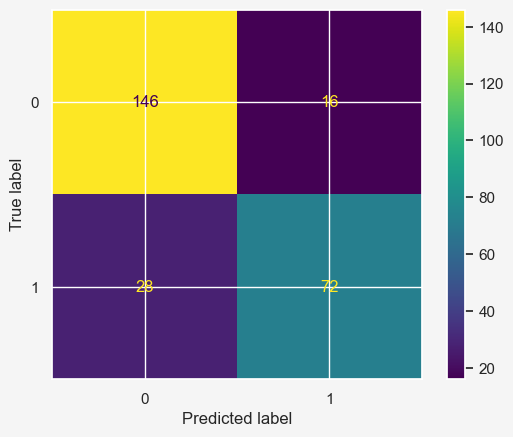

In [153]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

y_pred = best_model.predict(X_test_processed)
conf_matrix = confusion_matrix(y_test, y_pred, labels=None)
ConfusionMatrixDisplay(conf_matrix).plot()

##### False Positive

In [154]:
df_temp = df_test.copy()
df_temp['y_pred'] = y_pred
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
442,1.0,"Kreuchen, Miss. Emilie",female,39.0,0.0,0.0,24160,211.3375,None,S,None,1,1
891,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S,Spain,1,1
497,3.0,"Murdlin, Mr. Joseph",male,NaN,0.0,0.0,A./5. 3235,8.0500,None,S,None,0,0
1282,3.0,"Cacic, Mr. Jego Grga",male,18.0,0.0,0.0,315091,8.6625,None,S,None,0,0
412,1.0,"Stahelin-Maeglin, Dr. Max",male,32.0,0.0,0.0,13214,30.5000,B50,C,"Basel, Switzerland",1,1


In [155]:
# extract FP on test rows

df_fp = df_temp.loc[(df_temp['y_pred'] == "1") & (df_temp['survived'] == "0")]
df_fp.sort_values(['sex', 'pclass'], ascending=False)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
227,1.0,"Long, Mr. Milton Clyde",male,29.0,0.0,0.0,113501,30.0000,D6,S,"Springfield, MA",0,1
325,1.0,"Clark, Mr. Walter Miller",male,27.0,1.0,0.0,13508,136.7792,C89,C,"Los Angeles, CA",0,1
404,1.0,"Compton, Mr. Alexander Taylor Jr",male,37.0,1.0,1.0,PC 17756,83.1583,E52,C,"Lakewood, NJ",0,1
202,1.0,"Dulles, Mr. William Crothers",male,39.0,0.0,0.0,PC 17580,29.7000,A18,C,"Philadelphia, PA",0,1
1223,3.0,"McNeill, Miss. Bridget",female,NaN,0.0,0.0,370368,7.7500,None,Q,None,0,1
107,3.0,"O'Donoghue, Ms. Bridget",female,NaN,0.0,0.0,364856,7.7500,None,Q,None,0,1
261,3.0,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1.0,0.0,2689,14.4583,None,C,"Ottawa, ON",0,1
917,3.0,"Bourke, Miss. Mary",female,NaN,0.0,2.0,364848,7.7500,None,Q,"Ireland Chicago, IL",0,1
835,3.0,"Heininen, Miss. Wendla Maria",female,23.0,0.0,0.0,STON/O2. 3101290,7.9250,None,S,None,0,1
966,3.0,"Strom, Miss. Telma Matilda",female,2.0,0.0,1.0,347054,10.4625,G6,S,None,0,1


In [156]:
X_test_processed.loc[df_fp.index]

,cabin_ABC,cabin_DEFG,cabin_M,embarked_C,embarked_Q,embarked_S,family_size_alone,family_size_large,family_size_middle,title_Mr,title_Mrs,title_Ms,title_Rare,pclass,sex,age,has_cabin,fare_per_person
1223,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500
1146,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,50.0,1,28.7125
107,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500
227,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,29.0,1,30.0000
261,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0,22.0,0,14.4583
325,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,27.0,1,136.7792
837,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0,57.0,1,10.5000
799,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,18.0,0,13.0000
917,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500
404,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,37.0,1,83.1583


Explaining FP at index: 37


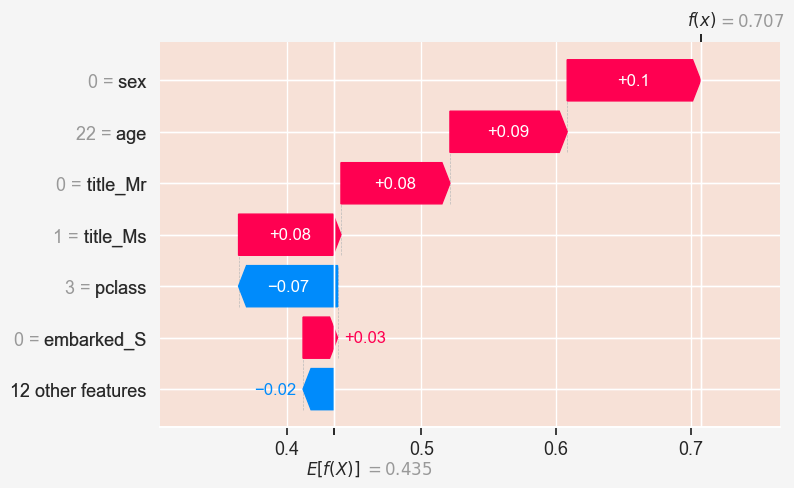

Explaining FP at index: 54


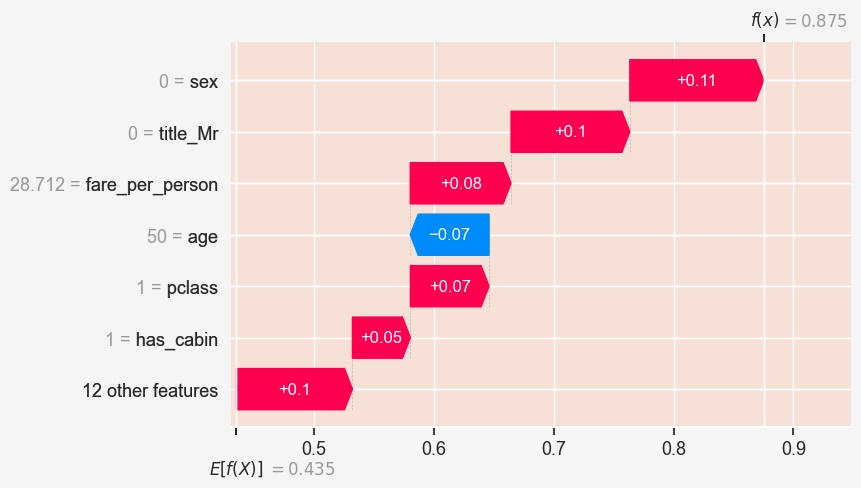

Explaining FP at index: 65


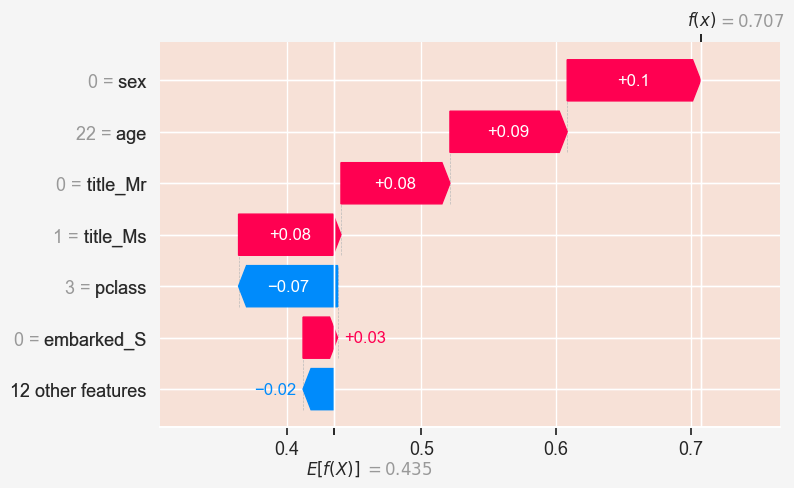

Explaining FP at index: 71


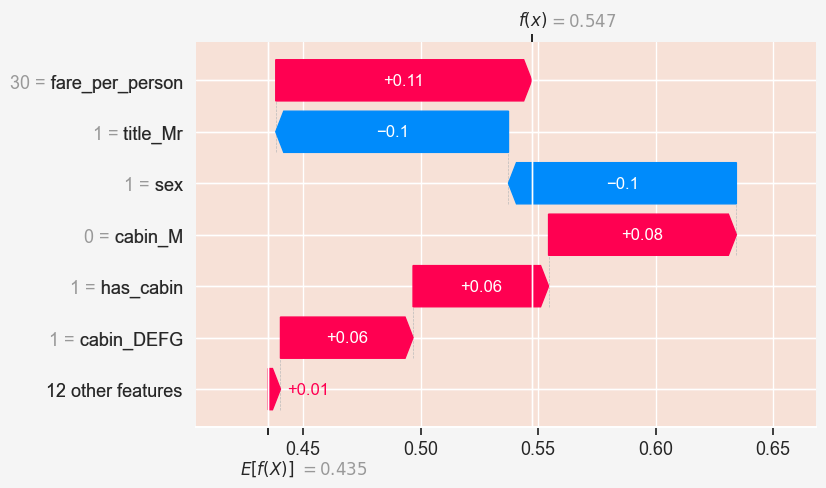

Explaining FP at index: 81


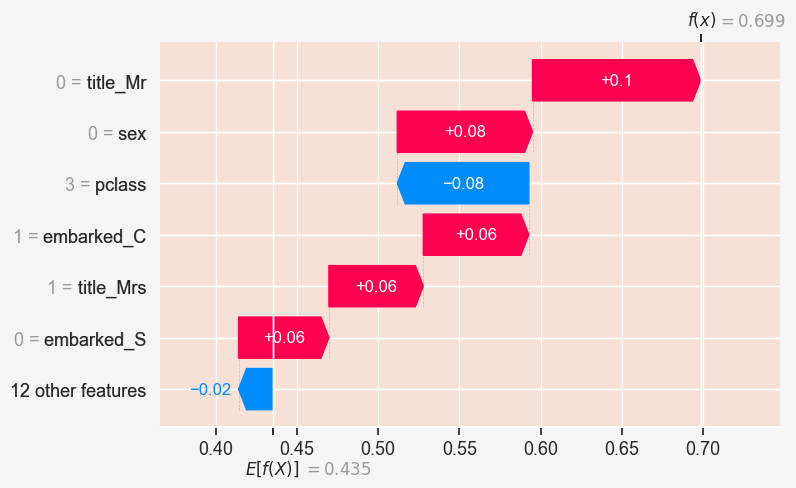

Explaining FP at index: 87


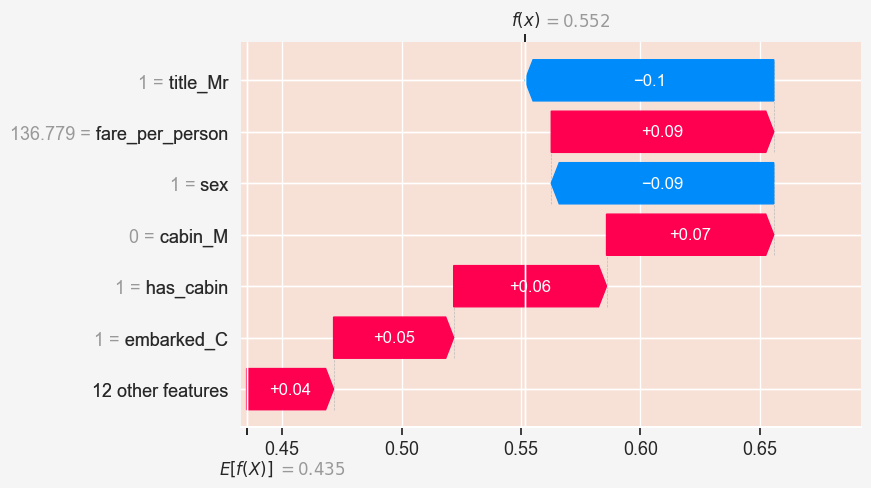

Explaining FP at index: 105


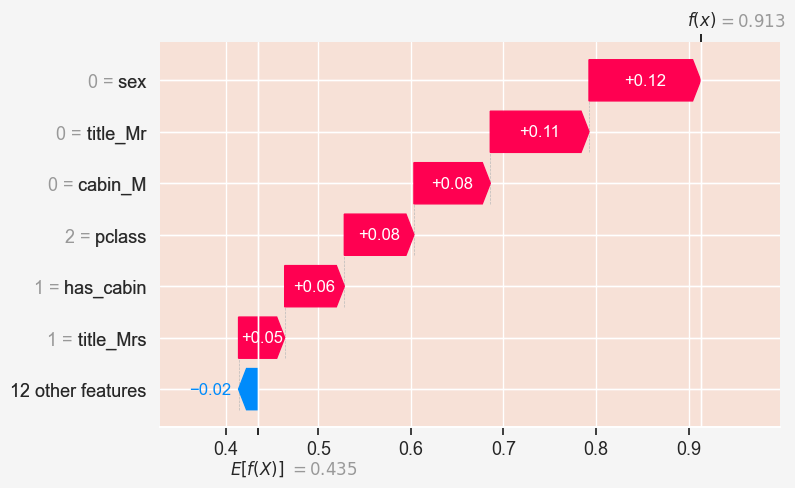

Explaining FP at index: 106


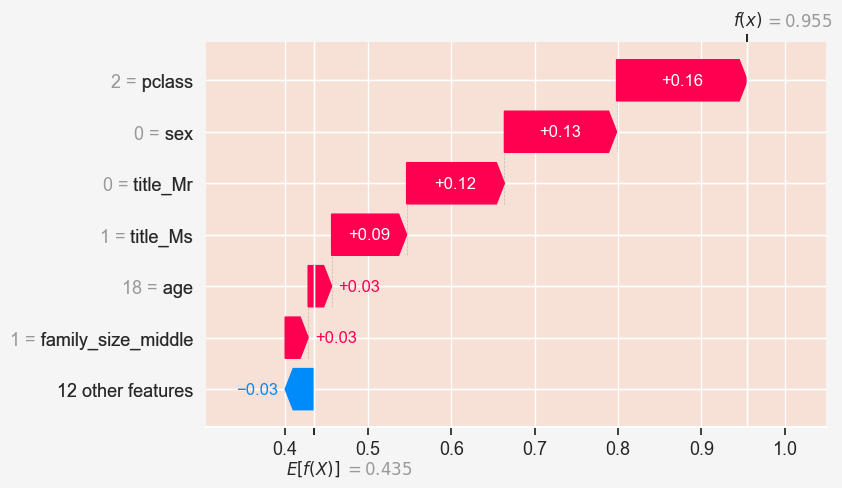

Explaining FP at index: 129


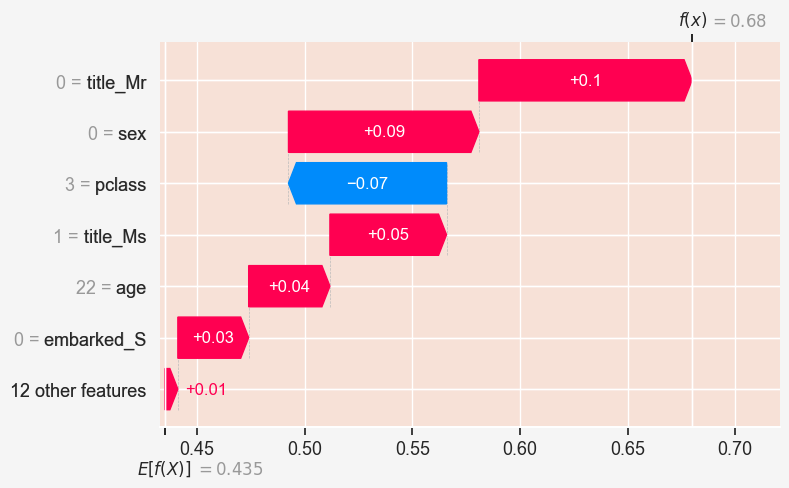

Explaining FP at index: 131


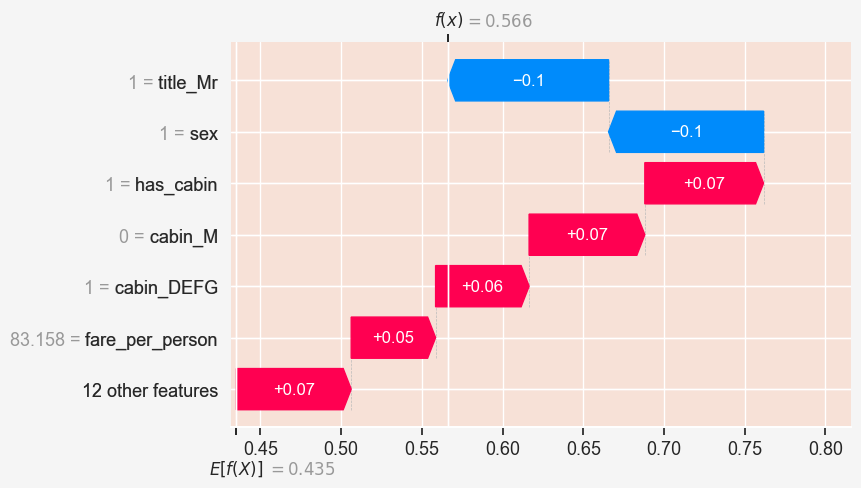

Explaining FP at index: 132


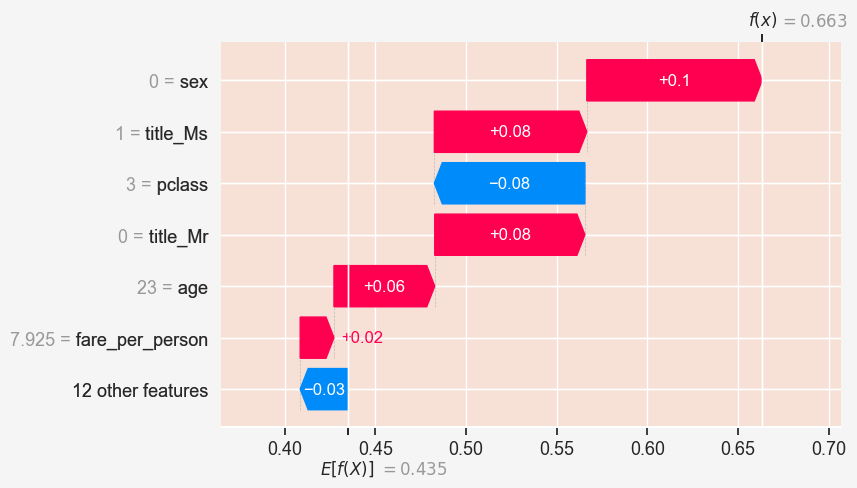

Explaining FP at index: 147


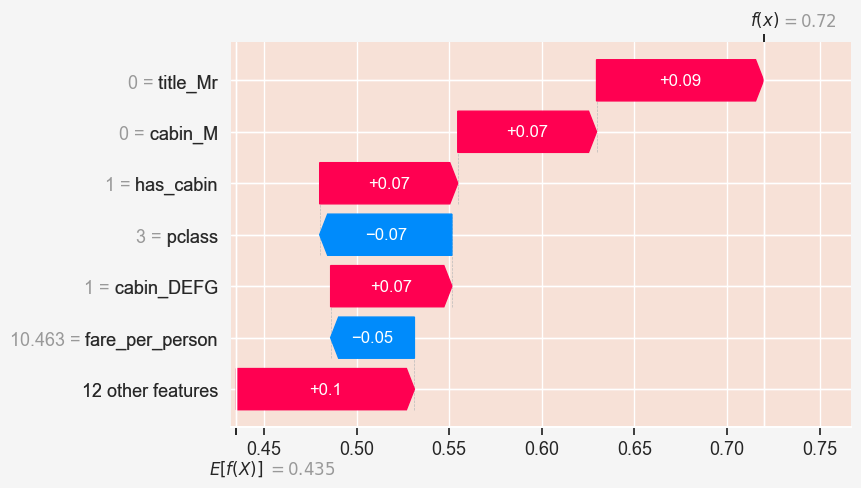

Explaining FP at index: 220


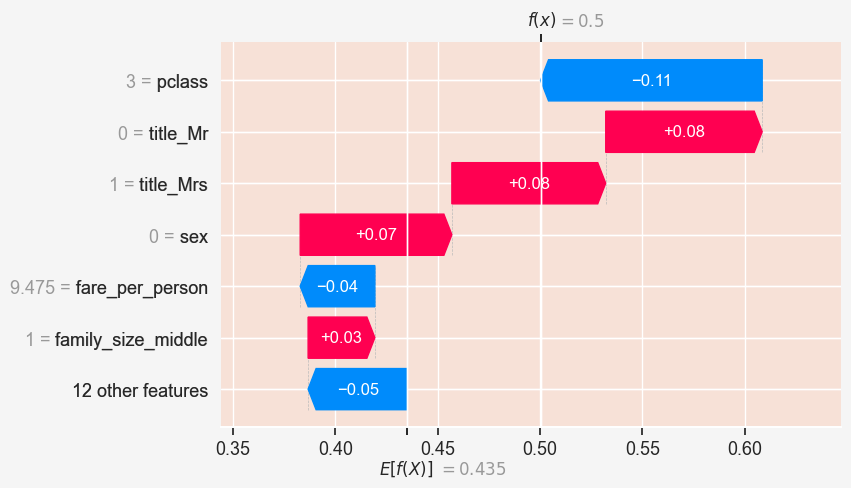

Explaining FP at index: 227


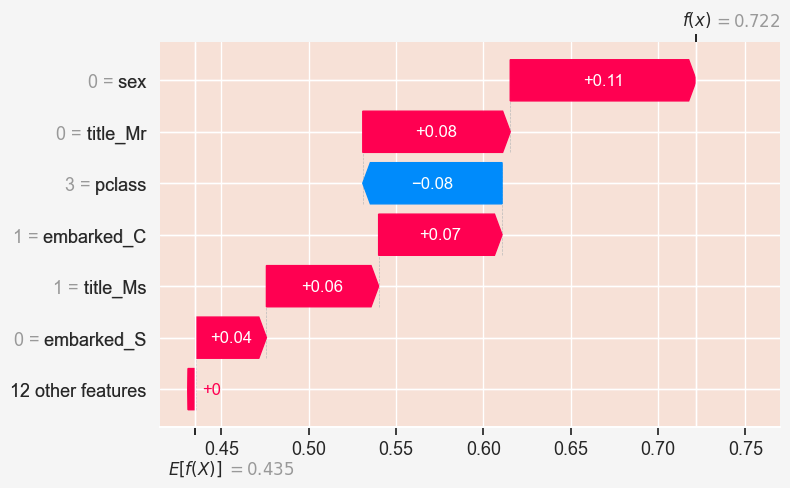

Explaining FP at index: 257


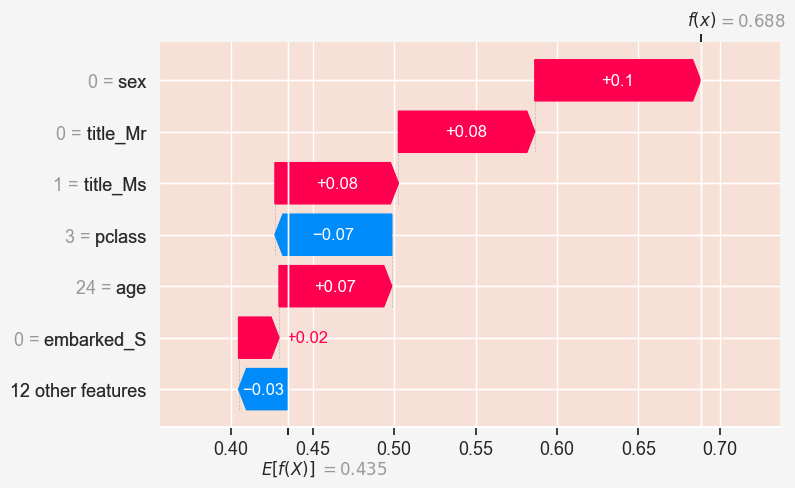

Explaining FP at index: 259


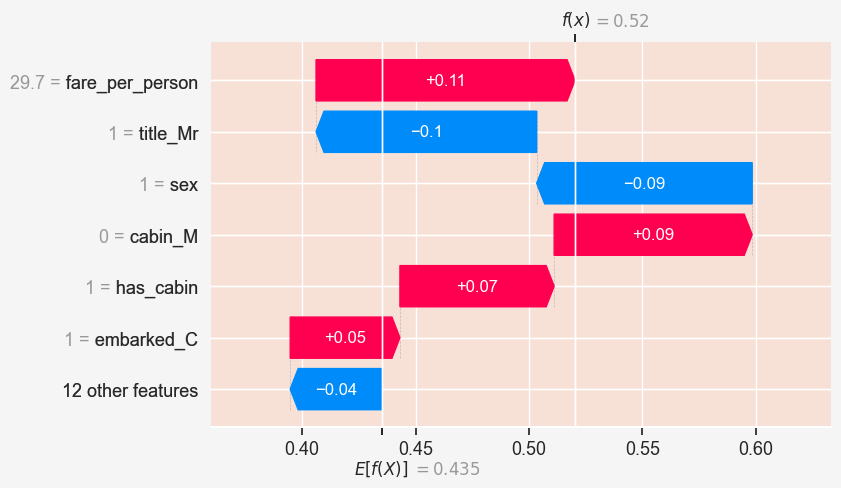

In [157]:
explainer = shap.TreeExplainer(best_model, X_train_processed)
shap_values = explainer(X_test_processed)
fp_indices = [X_test_processed.index.get_loc(idx) for idx in df_fp.index]

for i in fp_indices:
    print(f'Explaining FP at index: {i}')
    shap.plots.waterfall(shap_values[i, :, 1], max_display=7)

##### False Negative

In [158]:
df_temp = df_test.copy()
df_temp['y_pred'] = y_pred
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
442,1.0,"Kreuchen, Miss. Emilie",female,39.0,0.0,0.0,24160,211.3375,None,S,None,1,1
891,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S,Spain,1,1
497,3.0,"Murdlin, Mr. Joseph",male,NaN,0.0,0.0,A./5. 3235,8.0500,None,S,None,0,0
1282,3.0,"Cacic, Mr. Jego Grga",male,18.0,0.0,0.0,315091,8.6625,None,S,None,0,0
412,1.0,"Stahelin-Maeglin, Dr. Max",male,32.0,0.0,0.0,13214,30.5000,B50,C,"Basel, Switzerland",1,1


In [159]:
df_fn = df_temp[(df_temp['y_pred'] == "0") & (df_temp['survived'] == "1")]
df_fn

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
900,2.0,"Padro y Manent, Mr. Julian",male,NaN,0.0,0.0,SC/PARIS 2146,13.8625,None,C,"Spain / Havana, Cuba",1,0
1198,3.0,"Asplund, Master. Edvin Rojj Felix",male,3.0,4.0,2.0,347077,31.3875,None,S,"Sweden Worcester, MA",1,0
273,3.0,"Svensson, Mr. Johan Cervin",male,14.0,0.0,0.0,7538,9.2250,None,S,None,1,0
1274,3.0,"Hellstrom, Miss. Hilda Maria",female,22.0,0.0,0.0,7548,8.9625,None,S,None,1,0
84,1.0,"Snyder, Mr. John Pillsbury",male,24.0,1.0,0.0,21228,82.2667,B45,S,"Minneapolis, MN",1,0
690,1.0,"Chambers, Mr. Norman Campbell",male,27.0,1.0,0.0,113806,53.1000,E8,S,"New York, NY / Ithaca, NY",1,0
905,1.0,"Omont, Mr. Alfred Fernand",male,NaN,0.0,0.0,F.C. 12998,25.7417,None,C,"Paris, France",1,0
962,3.0,"Jansson, Mr. Carl Olof",male,21.0,0.0,0.0,350034,7.7958,None,S,None,1,0
77,3.0,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",female,22.0,1.0,0.0,347072,13.9000,None,S,"West Haven, CT",1,0
127,1.0,"Homer, Mr. Harry ('Mr E Haven')",male,35.0,0.0,0.0,111426,26.5500,None,C,"Indianapolis, IN",1,0


In [160]:
X_test_processed.loc[df_fn.index].sort_values('pclass')

,cabin_ABC,cabin_DEFG,cabin_M,embarked_C,embarked_Q,embarked_S,family_size_alone,family_size_large,family_size_middle,title_Mr,title_Mrs,title_Ms,title_Rare,pclass,sex,age,has_cabin,fare_per_person
690,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,27.0,1,53.1000
905,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,40.5,0,25.7417
84,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,24.0,1,82.2667
127,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,35.0,0,26.5500
1184,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,34.0,0,26.5500
795,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,42.0,1,26.2875
427,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,80.0,1,30.0000
920,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1.0,1,50.0,0,133.6500
1201,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,49.0,1,0.0000
322,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,40.5,0,26.5500


Explaining FN at index: 6


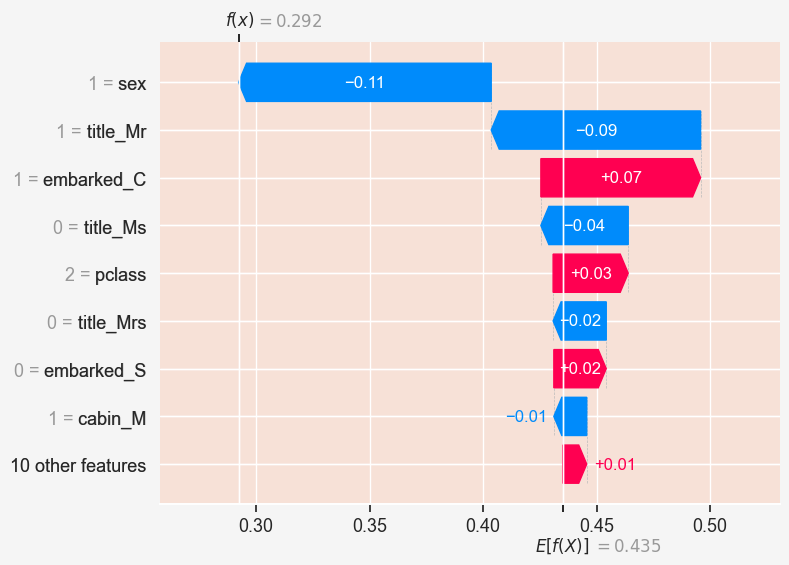

Explaining FN at index: 13


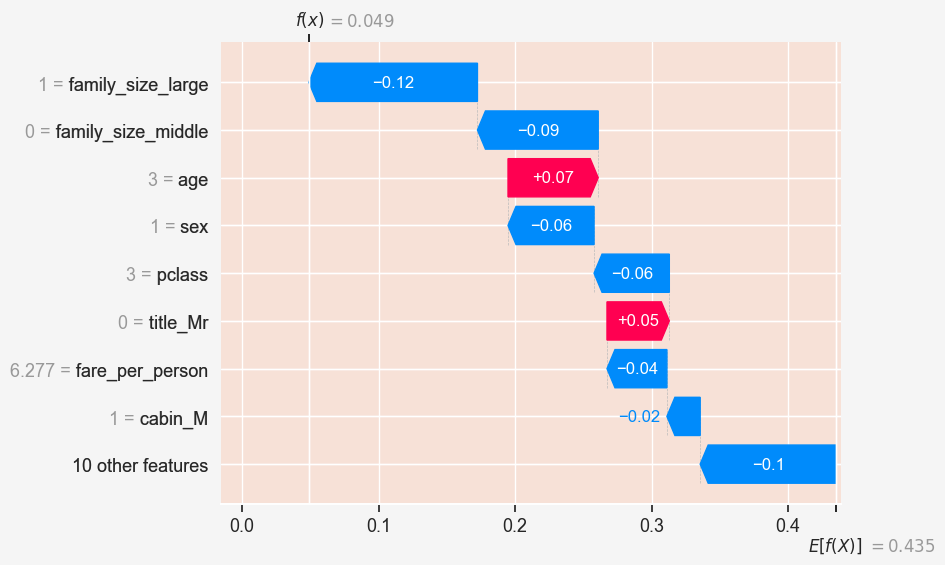

Explaining FN at index: 20


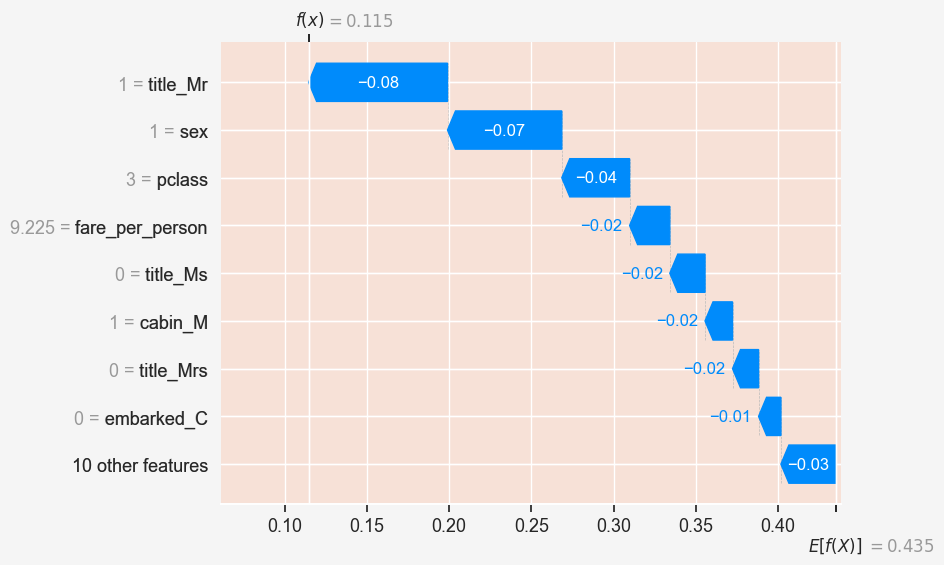

Explaining FN at index: 47


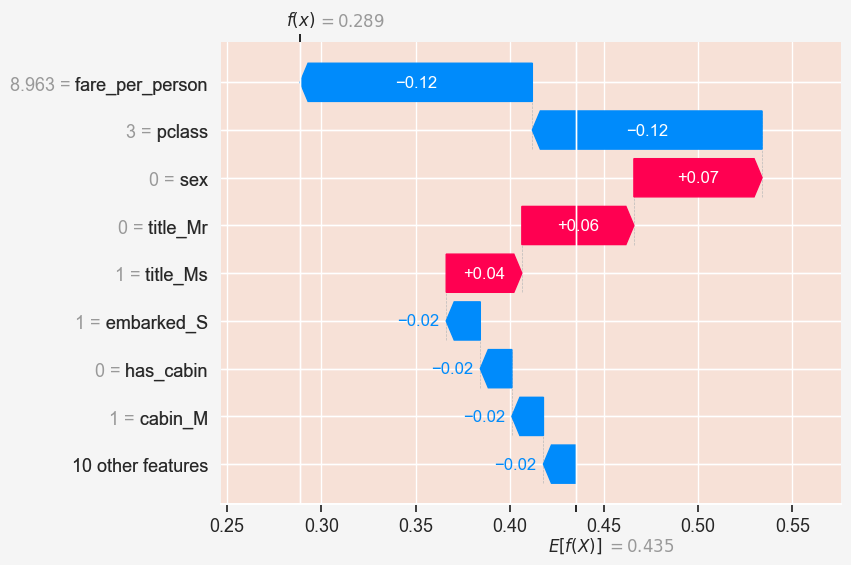

Explaining FN at index: 69


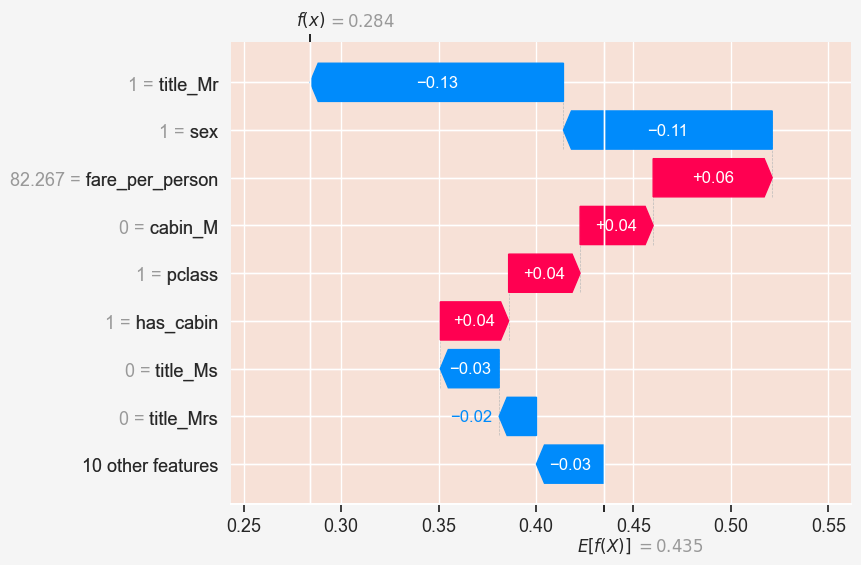

Explaining FN at index: 75


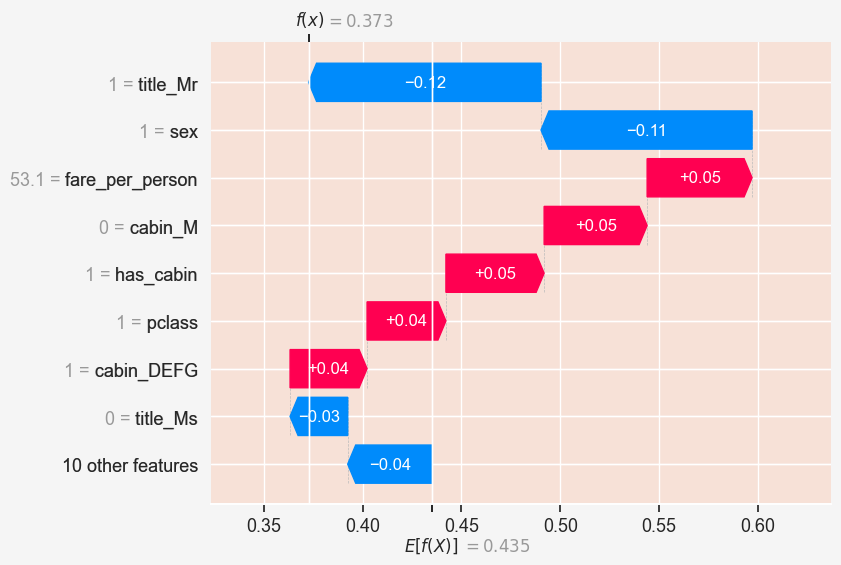

Explaining FN at index: 77


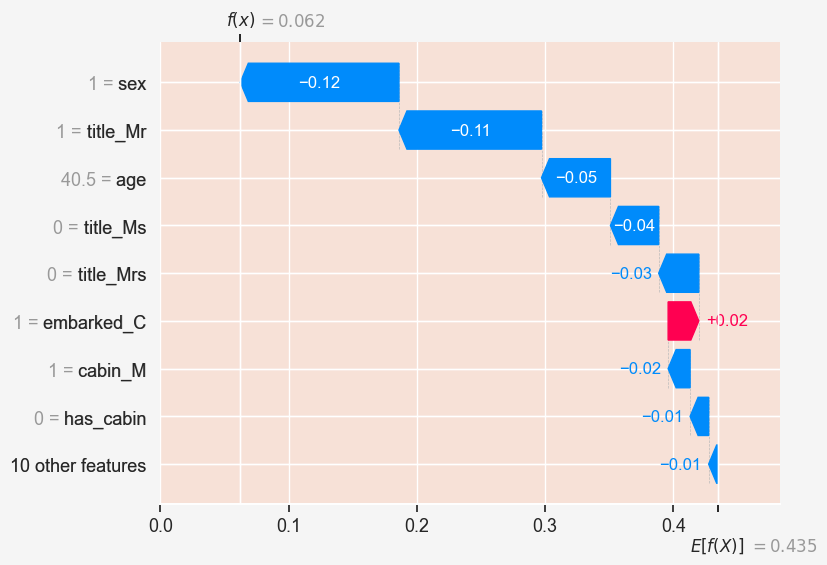

Explaining FN at index: 86


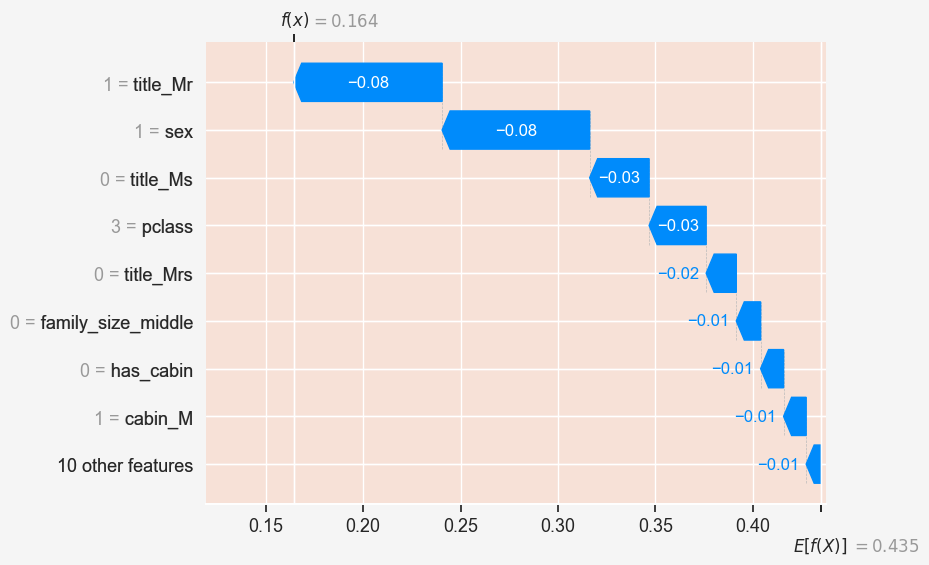

Explaining FN at index: 123


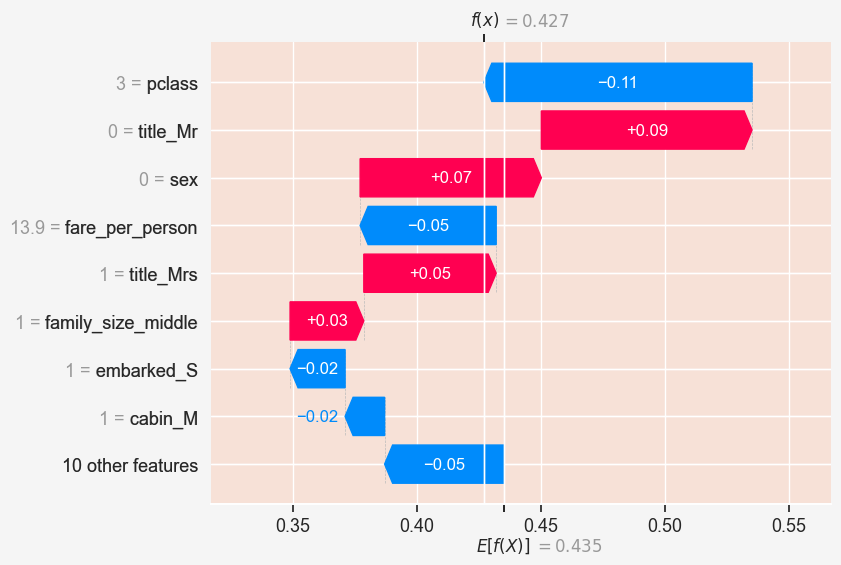

Explaining FN at index: 138


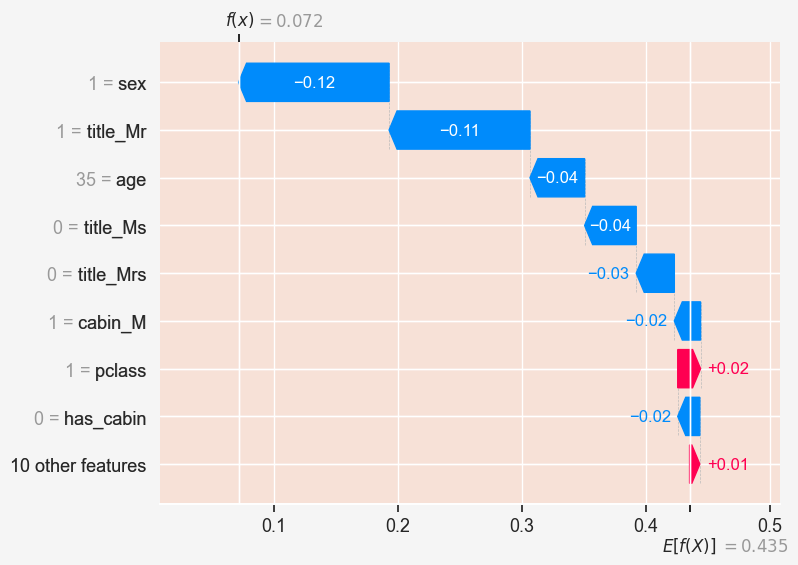

Explaining FN at index: 140


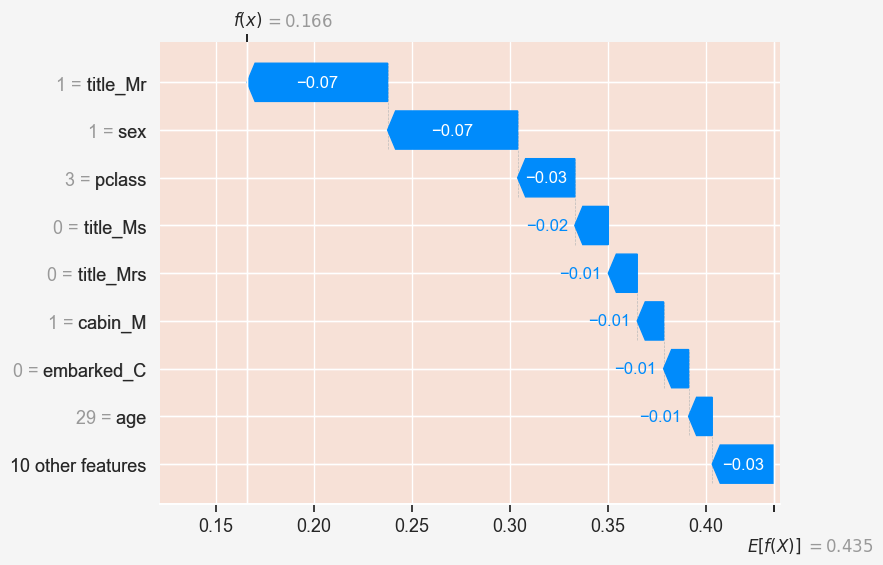

Explaining FN at index: 145


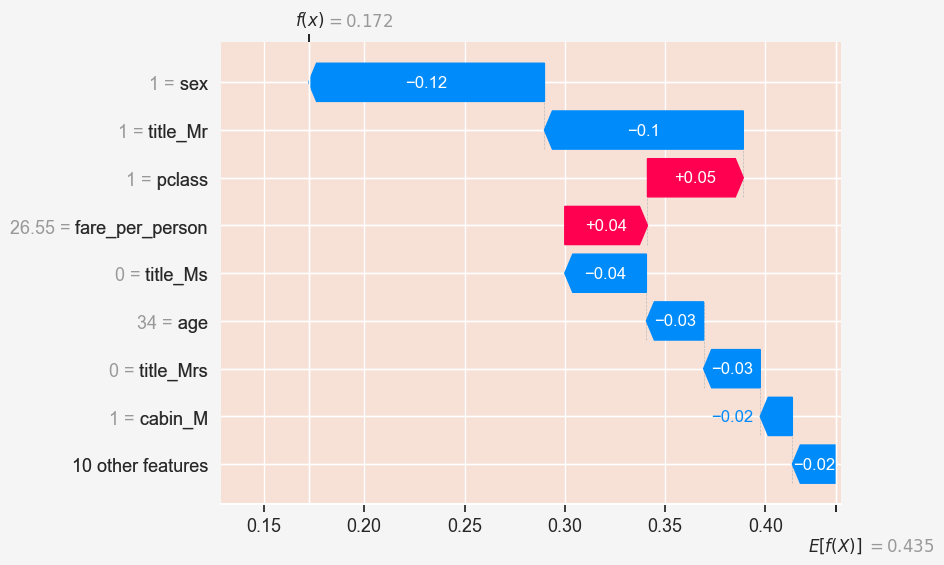

Explaining FN at index: 156


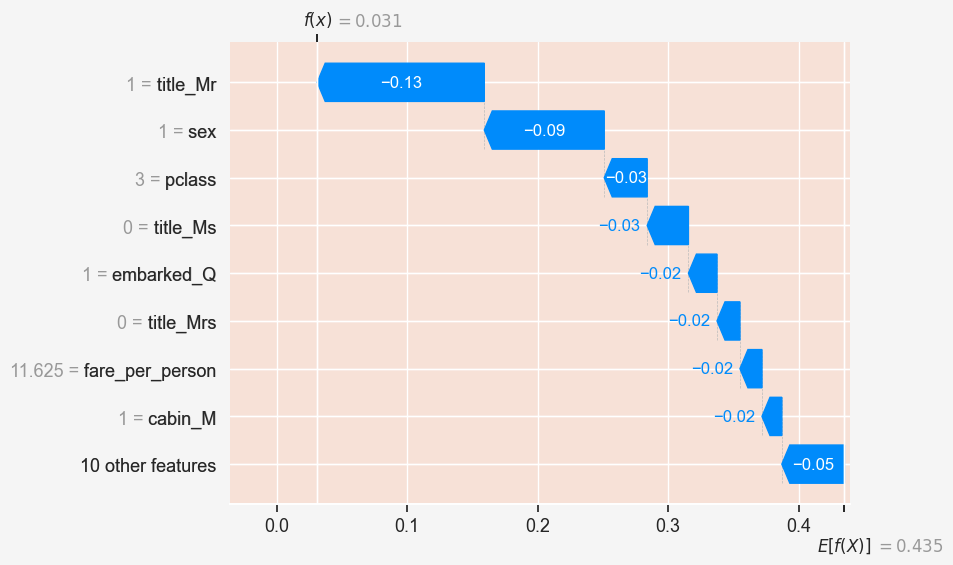

Explaining FN at index: 171


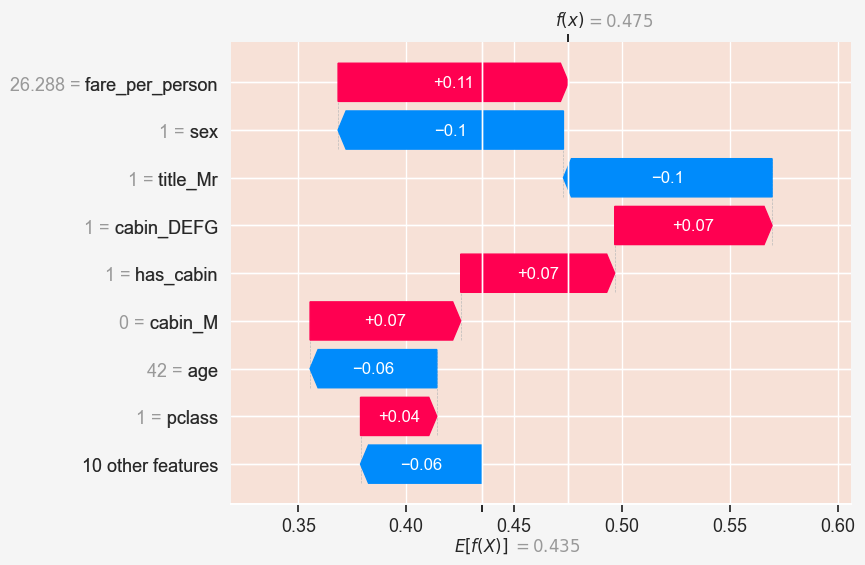

Explaining FN at index: 175


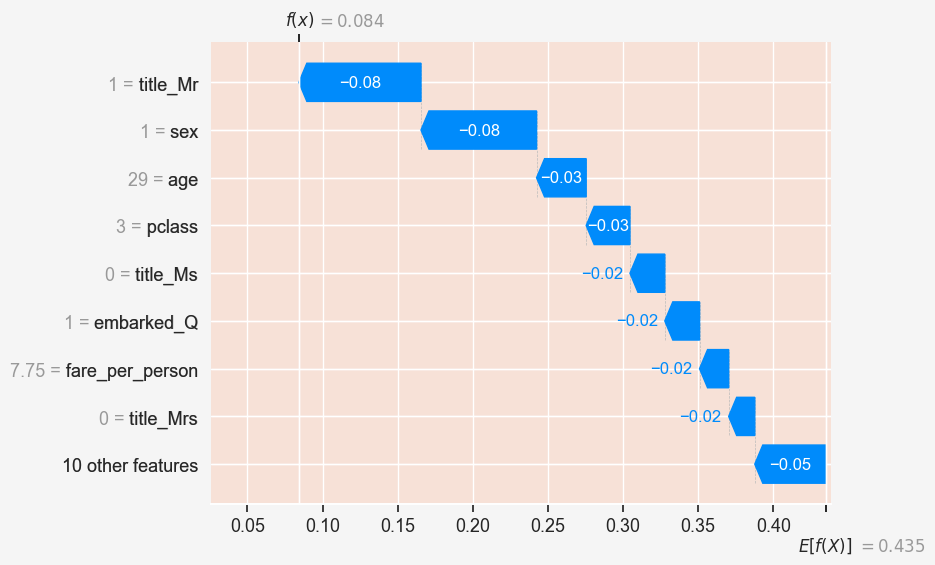

Explaining FN at index: 186


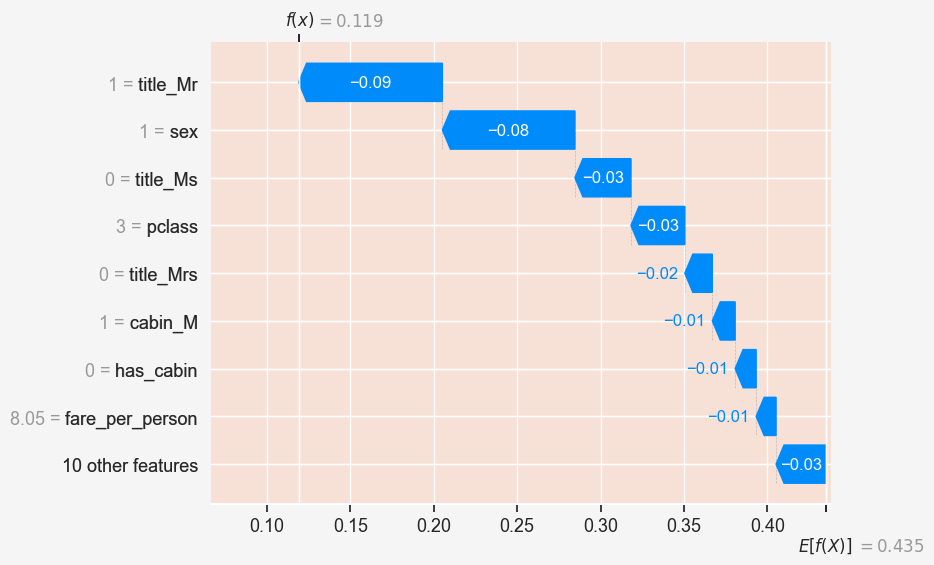

Explaining FN at index: 191


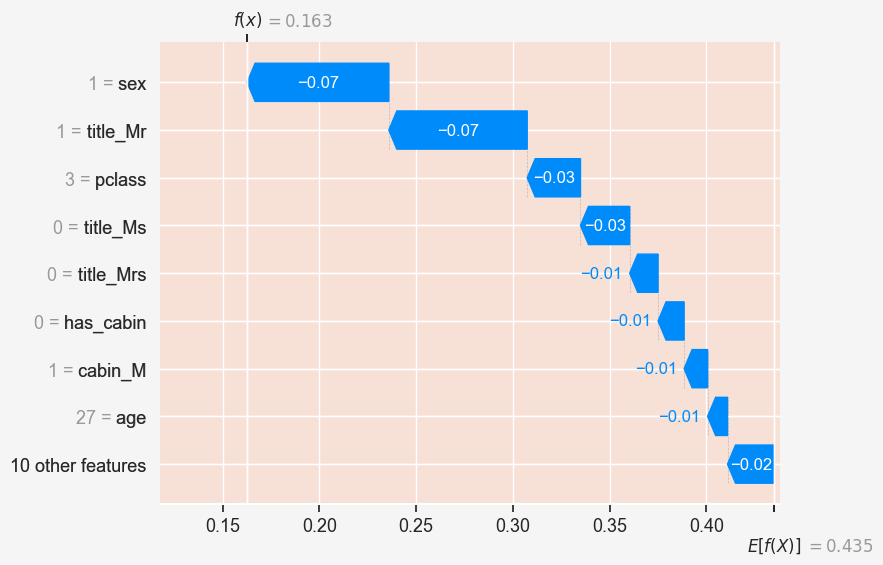

Explaining FN at index: 194


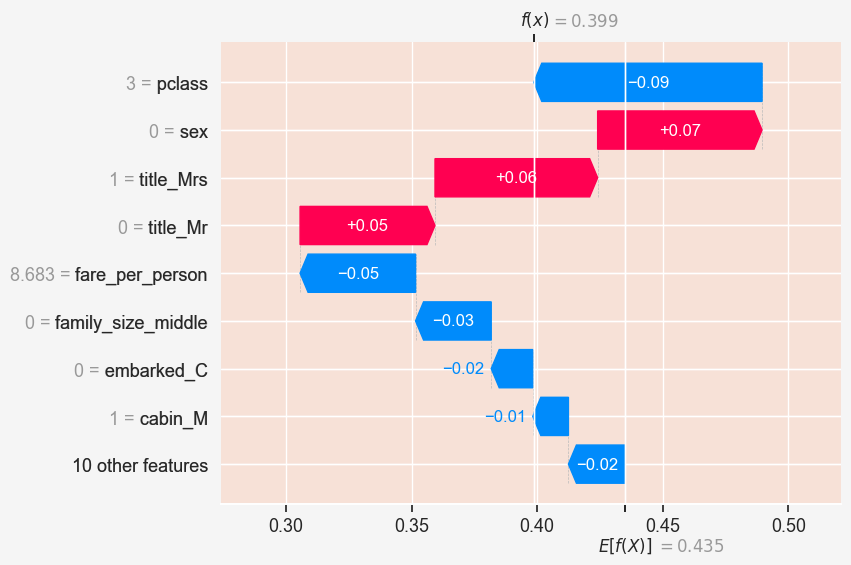

Explaining FN at index: 196


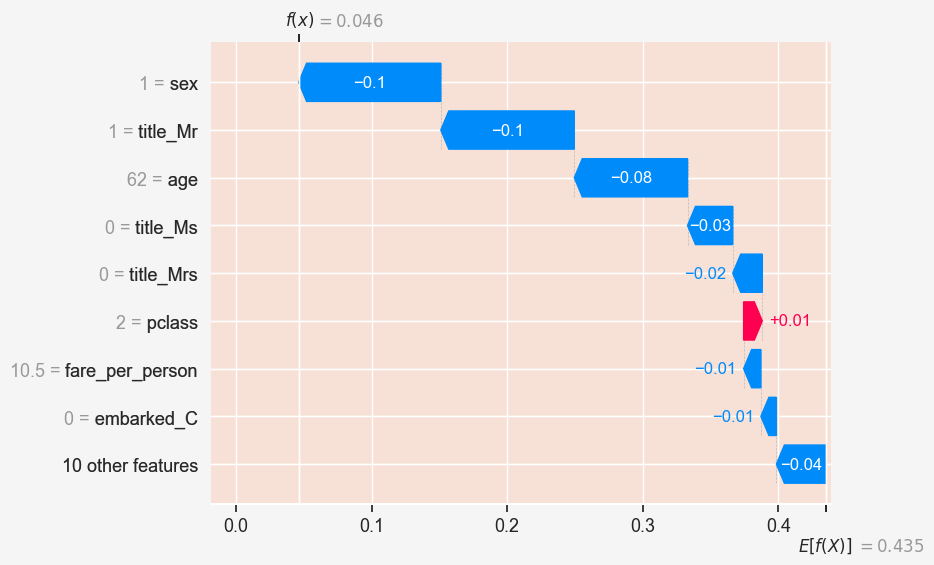

Explaining FN at index: 200


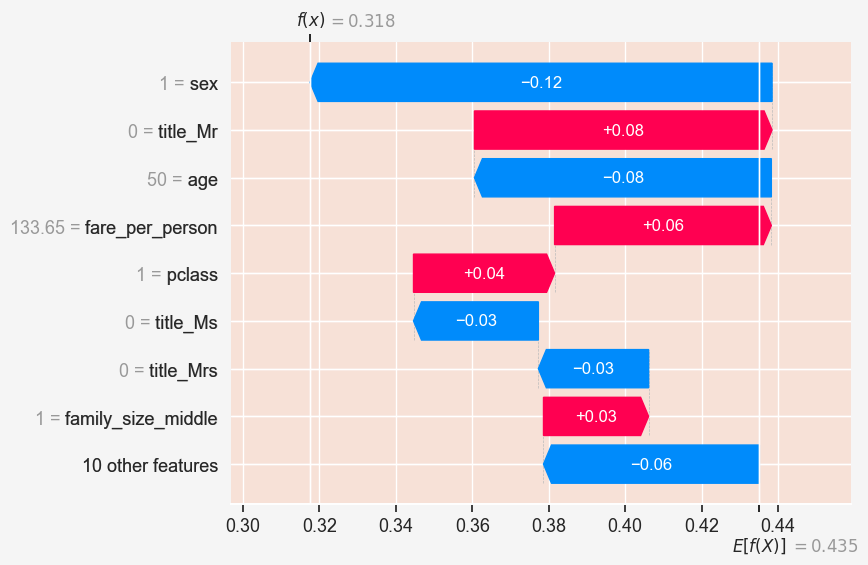

Explaining FN at index: 205


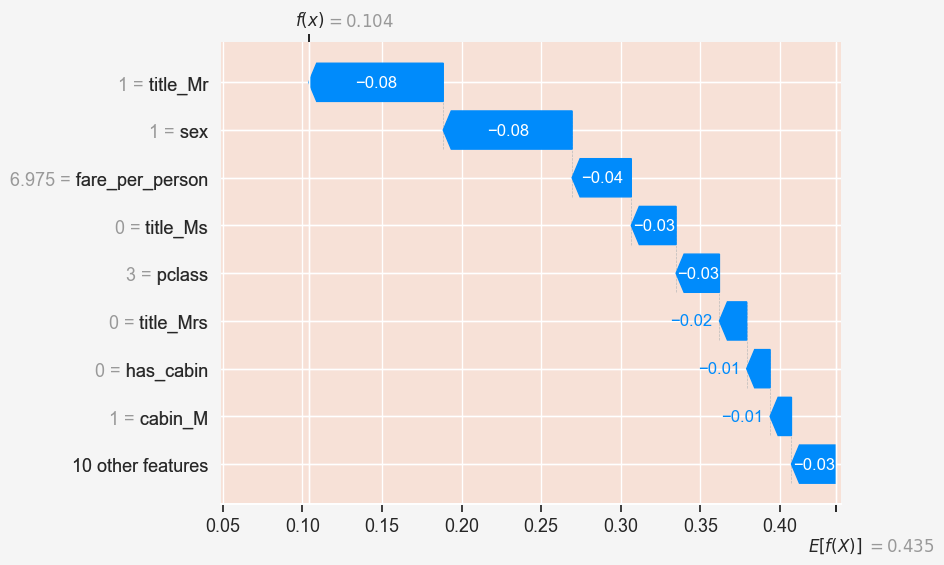

Explaining FN at index: 211


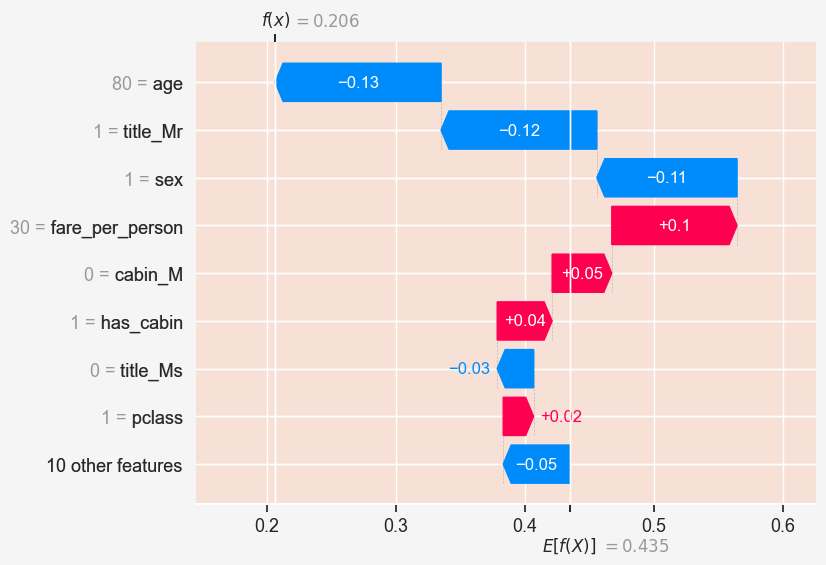

Explaining FN at index: 222


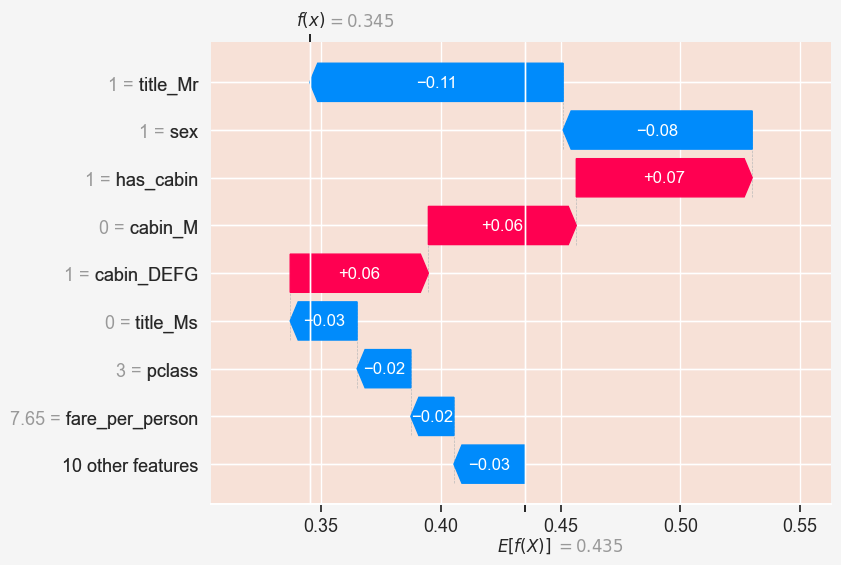

Explaining FN at index: 234


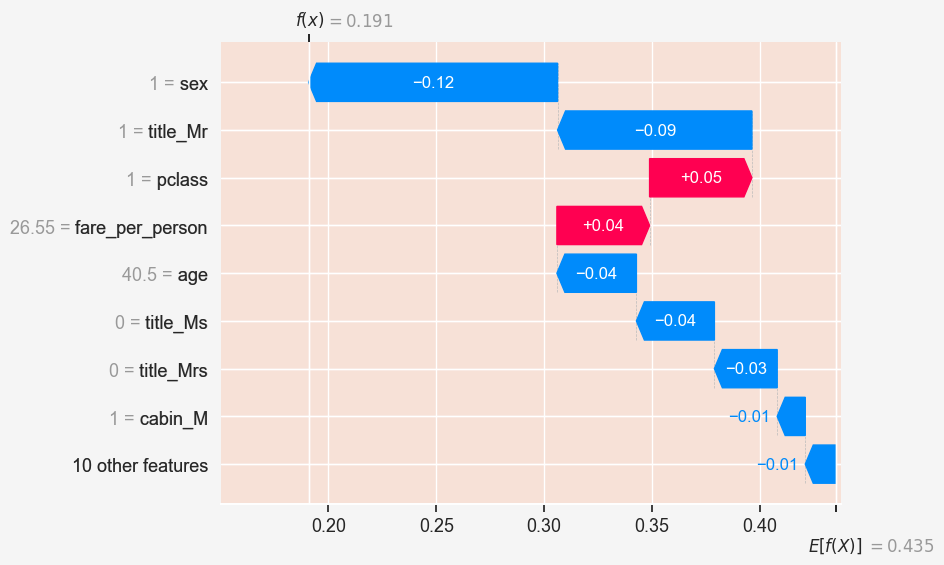

Explaining FN at index: 235


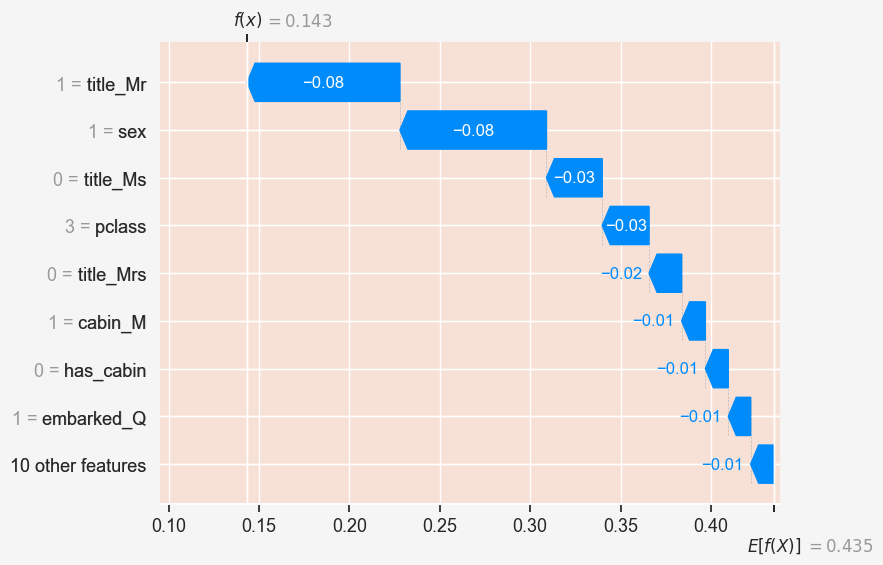

Explaining FN at index: 241


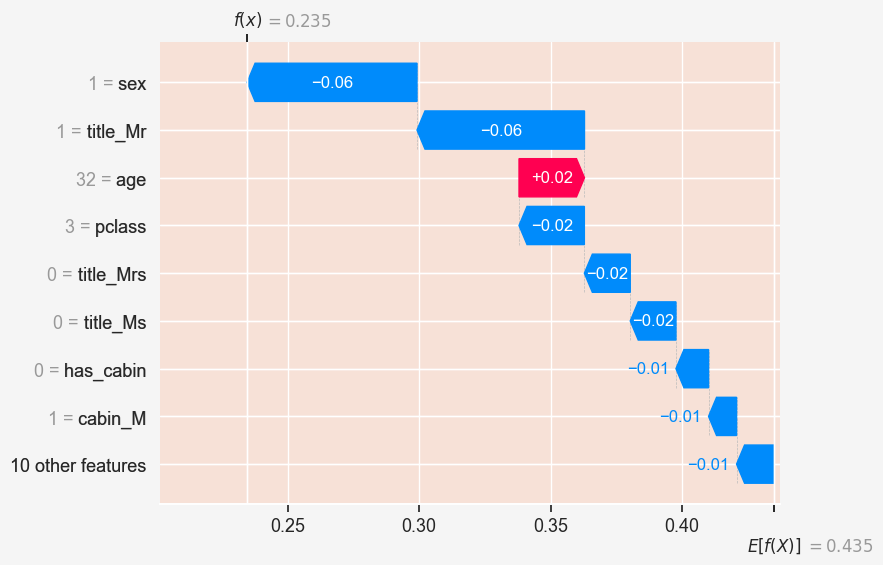

Explaining FN at index: 256


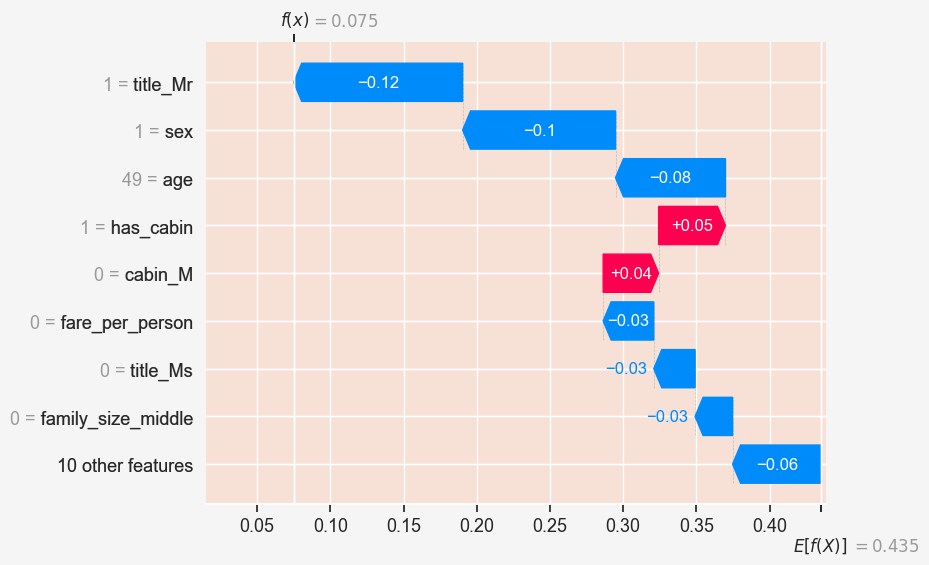

Explaining FN at index: 261


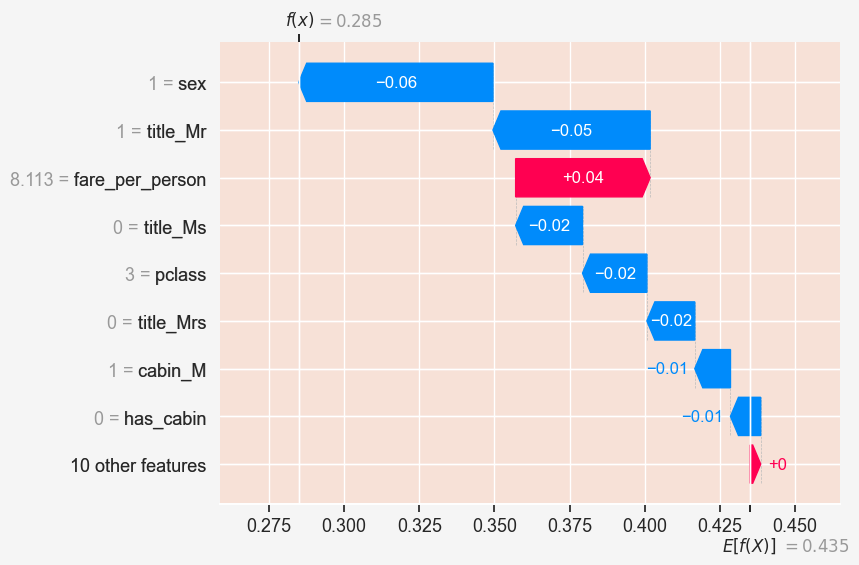

In [161]:
explainer = shap.TreeExplainer(best_model, X_train_processed)
shap_values = explainer(X_test_processed)
fn_indices = [X_test_processed.index.get_loc(idx) for idx in df_fn.index]

for i in fn_indices:
    print(f'Explaining FN at index: {i}')
    shap.plots.waterfall(shap_values[i, :, 1], max_display=9)

Feature Improvement Plan:

- Create feature interactions between female passengers and 3rd class.
- Create feature interactions between female passangers and no cabin.
- Use more sophisticated imputation strategies for age: find `Ms` and `Miss`, and look for the total of accompanying family. There is a chance if `parch` > 0 then the passanger is a child.

## 2nd Exploration

### Feature Engineering

#### Female passengers and 3rd class

In [75]:
df_temp = df_train.copy()
df_temp['is_female_3rd_class'] = ((df_temp['sex'] == 'female') & (df_temp['pclass'] == 3)) * 1
df_temp.sample(10, random_state=29)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,is_female_3rd_class
500,3.0,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,NaN,0.0,0.0,65305,8.1125,None,S,None,0,1
644,3.0,"Goodwin, Miss. Lillian Amy",female,16.0,5.0,2.0,CA 2144,46.9000,None,S,"Wiltshire, England Niagara Falls, NY",0,1
1242,2.0,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0.0,0.0,SC/AH Basle 541,13.7917,D,C,"New York, NY",1,0
1030,2.0,"Downton, Mr. William James",male,54.0,0.0,0.0,28403,26.0000,None,S,"Holley, NY",0,0
949,3.0,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3.0,0.0,3101278,15.8500,None,S,"Ruotsinphytaa, Finland New York, NY",1,1
234,3.0,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1.0,0.0,STON/O2. 3101279,15.8500,None,S,None,1,1
1286,3.0,"Bourke, Mr. John",male,40.0,1.0,1.0,364849,15.5000,None,Q,"Ireland Chicago, IL",0,0
1155,3.0,"Finoli, Mr. Luigi",male,NaN,0.0,0.0,SOTON/O.Q. 3101308,7.0500,None,S,"Italy Philadelphia, PA",1,0
1195,1.0,"Crafton, Mr. John Bertram",male,NaN,0.0,0.0,113791,26.5500,None,S,"Roachdale, IN",0,0
1295,3.0,"Moubarek, Mrs. George (Omine 'Amenia' Alexander)",female,NaN,0.0,2.0,2661,15.2458,None,C,None,1,1


In [76]:
def apply_gender_pclass_interaction(df):
    df_copy = df.copy()
    df_copy['is_female_3rd_class'] = (
        ((df_copy['sex'] == 'female') & (df_copy['pclass'] == 3)) * 1
    )
    return df_copy

In [77]:
df_temp = apply_gender_pclass_interaction(X_test)
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,is_female_3rd_class
442,1.0,"Kreuchen, Miss. Emilie",female,39.0,0.0,0.0,24160,211.3375,None,S,None,0
891,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S,Spain,0
497,3.0,"Murdlin, Mr. Joseph",male,NaN,0.0,0.0,A./5. 3235,8.0500,None,S,None,0
1282,3.0,"Cacic, Mr. Jego Grga",male,18.0,0.0,0.0,315091,8.6625,None,S,None,0
412,1.0,"Stahelin-Maeglin, Dr. Max",male,32.0,0.0,0.0,13214,30.5000,B50,C,"Basel, Switzerland",0


#### Female passengers and no cabin

In [78]:
df_temp = df_train.copy()
df_temp['has_cabin'] = df_temp['cabin'].isna() * 1
df_temp['is_female_no_cabin'] = (
    ((df_temp['sex'] == 'female') & (df_temp['has_cabin'] == 0)) * 1
)
df_temp.sample(10, random_state=29)

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,has_cabin,is_female_no_cabin
500,3.0,"Rasmussen, Mrs. (Lena Jacobsen Solvang)",female,NaN,0.0,0.0,65305,8.1125,None,S,None,0,1,0
644,3.0,"Goodwin, Miss. Lillian Amy",female,16.0,5.0,2.0,CA 2144,46.9000,None,S,"Wiltshire, England Niagara Falls, NY",0,1,0
1242,2.0,"Jerwan, Mrs. Amin S (Marie Marthe Thuillard)",female,23.0,0.0,0.0,SC/AH Basle 541,13.7917,D,C,"New York, NY",1,0,1
1030,2.0,"Downton, Mr. William James",male,54.0,0.0,0.0,28403,26.0000,None,S,"Holley, NY",0,1,0
949,3.0,"Backstrom, Mrs. Karl Alfred (Maria Mathilda Gu...",female,33.0,3.0,0.0,3101278,15.8500,None,S,"Ruotsinphytaa, Finland New York, NY",1,1,0
234,3.0,"Hakkarainen, Mrs. Pekka Pietari (Elin Matilda ...",female,24.0,1.0,0.0,STON/O2. 3101279,15.8500,None,S,None,1,1,0
1286,3.0,"Bourke, Mr. John",male,40.0,1.0,1.0,364849,15.5000,None,Q,"Ireland Chicago, IL",0,1,0
1155,3.0,"Finoli, Mr. Luigi",male,NaN,0.0,0.0,SOTON/O.Q. 3101308,7.0500,None,S,"Italy Philadelphia, PA",1,1,0
1195,1.0,"Crafton, Mr. John Bertram",male,NaN,0.0,0.0,113791,26.5500,None,S,"Roachdale, IN",0,1,0
1295,3.0,"Moubarek, Mrs. George (Omine 'Amenia' Alexander)",female,NaN,0.0,2.0,2661,15.2458,None,C,None,1,1,0


In [79]:
def apply_gender_cabin_interaction(df):
    df_copy = df.copy()
    df_copy['is_female_no_cabin'] = (
        ((df_copy['sex'] == 'female') & (df_copy['has_cabin'] == 0)) * 1
    )
    return df_copy

### Modeling

In [80]:
def preprocessing(df):
    df_copy = df.copy()
    df_copy = remove_home_dest(df)
    df_copy = apply_age_feature(df_copy, age_lookup)
    df_copy = apply_cabin_feature(df_copy)
    df_copy = apply_family_size_feature(df_copy)
    df_copy = apply_name_feature(df_copy)
    df_copy = apply_fare_feature(df_copy, ticket_counts, fare_lookup)
    df_copy = apply_embarked_feature(df_copy, embarked_mode)
    df_copy = apply_gender_pclass_interaction(df_copy)
    df_copy = apply_gender_cabin_interaction(df_copy)
    df_copy = apply_sex_feature(df_copy)
    df_copy = apply_ohe(df_copy, transformer)
    return df_copy

In [81]:
X_train_processed = preprocessing(X_train)
X_test_processed = preprocessing(X_test)

In [82]:
param_grids = {
    "log_reg": {
        'C': [0.01, 0.1, 1, 10], 
        'penalty': ['l1', 'l2'],
        'max_iter': [100000],
        'solver': ['liblinear']
    },
    "dt": {
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4]
    },
    "rf": {
        'n_estimators': [50, 100],
        'max_depth': [3, 5, 10],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    },
    "hist_boost": {
        'learning_rate': [0.01, 0.05, 0.1],
        'max_iter': [100, 150],
        'max_depth': [3, 5],
        'l2_regularization': [0, 0.1, 1.0]
    }
}
cv_results = []
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=29)

for name, model in models.items():
    print(f"Tuning {name}...")
    cv_search = RandomizedSearchCV(
        estimator=model, 
        param_distributions=param_grids[name], 
        cv=skf, 
        scoring='accuracy',
        random_state=29
    )
    cv_search.fit(X_train_processed, y_train)
    models[name] = cv_search.best_estimator_
    cv_results.append({
        'model': name,
        'best_cv_accuracy': cv_search.best_score_,
        'test_accuracy': cv_search.score(X_test_processed, y_test),
        'best_params': cv_search.best_params_
    })

df_results = (
    pd.DataFrame(cv_results)
    .set_index('model')
    .sort_values('test_accuracy', ascending=False)
)
print("\nFinal Results:")
df_results

Tuning log_reg...


/Users/bening/Code/_data_portfolios/titanic-challenge/.venv/lib/python3.12/site-packages/sklearn/model_selection/_search.py:317: UserWarning: The total space of parameters 8 is smaller than n_iter=10. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Tuning dt...
Tuning hist_boost...
Tuning rf...

Final Results:


,best_cv_accuracy,test_accuracy,best_params
model,,,
rf,0.831925,0.832061,"{'n_estimators': 100, 'min_samples_split': 10,..."
log_reg,0.816619,0.828244,"{'solver': 'liblinear', 'penalty': 'l1', 'max_..."
hist_boost,0.828107,0.820611,"{'max_iter': 100, 'max_depth': 5, 'learning_ra..."
dt,0.817585,0.805344,"{'min_samples_split': 10, 'min_samples_leaf': ..."


### Interpreting Models

In [83]:
best_model_name = df_results.index[0]
best_model = models[best_model_name]

In [84]:
df_feature_importance = pd.DataFrame({
    'feature': X_train_processed.columns,
    'importance': best_model.feature_importances_
})
df_feature_importance.sort_values(by='importance', ascending=False)

,feature,importance
14,sex,0.166127
9,title_Mr,0.165449
17,fare_per_person,0.136249
15,age,0.120436
10,title_Mrs,0.048457
13,pclass,0.047137
11,title_Ms,0.043723
19,is_female_no_cabin,0.037989
16,has_cabin,0.033837
7,family_size_large,0.033721


#### Analyze Misclassified Instances

##### False Positive

In [85]:
df_temp = df_test.copy()
df_temp['y_pred'] = y_pred
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
442,1.0,"Kreuchen, Miss. Emilie",female,39.0,0.0,0.0,24160,211.3375,None,S,None,1,1
891,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S,Spain,1,1
497,3.0,"Murdlin, Mr. Joseph",male,NaN,0.0,0.0,A./5. 3235,8.0500,None,S,None,0,0
1282,3.0,"Cacic, Mr. Jego Grga",male,18.0,0.0,0.0,315091,8.6625,None,S,None,0,0
412,1.0,"Stahelin-Maeglin, Dr. Max",male,32.0,0.0,0.0,13214,30.5000,B50,C,"Basel, Switzerland",1,1


In [86]:
# extract FP on test rows

df_fp = df_temp.loc[(df_temp['y_pred'] == "1") & (df_temp['survived'] == "0")]
df_fp

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
1223,3.0,"McNeill, Miss. Bridget",female,NaN,0.0,0.0,370368,7.7500,None,Q,None,0,1
1146,1.0,"Isham, Miss. Ann Elizabeth",female,50.0,0.0,0.0,PC 17595,28.7125,C49,C,"Paris, France New York, NY",0,1
107,3.0,"O'Donoghue, Ms. Bridget",female,NaN,0.0,0.0,364856,7.7500,None,Q,None,0,1
227,1.0,"Long, Mr. Milton Clyde",male,29.0,0.0,0.0,113501,30.0000,D6,S,"Springfield, MA",0,1
261,3.0,"Caram, Mrs. Joseph (Maria Elias)",female,NaN,1.0,0.0,2689,14.4583,None,C,"Ottawa, ON",0,1
325,1.0,"Clark, Mr. Walter Miller",male,27.0,1.0,0.0,13508,136.7792,C89,C,"Los Angeles, CA",0,1
837,2.0,"Mack, Mrs. (Mary)",female,57.0,0.0,0.0,S.O./P.P. 3,10.5000,E77,S,"Southampton / New York, NY",0,1
799,2.0,"Hiltunen, Miss. Marta",female,18.0,1.0,1.0,250650,13.0000,None,S,"Kontiolahti, Finland / Detroit, MI",0,1
917,3.0,"Bourke, Miss. Mary",female,NaN,0.0,2.0,364848,7.7500,None,Q,"Ireland Chicago, IL",0,1
404,1.0,"Compton, Mr. Alexander Taylor Jr",male,37.0,1.0,1.0,PC 17756,83.1583,E52,C,"Lakewood, NJ",0,1


In [87]:
df_temp_processed = X_test_processed.copy()
df_temp_processed['y_pred'] = y_pred
df_temp_processed['survived'] = y_test
df_temp_processed.loc[(df_temp_processed['y_pred'] == "1") & (df_temp_processed['survived'] == "0")]

,cabin_ABC,cabin_DEFG,cabin_M,embarked_C,embarked_Q,embarked_S,family_size_alone,family_size_large,family_size_middle,title_Mr,title_Mrs,title_Ms,title_Rare,pclass,sex,age,has_cabin,fare_per_person,is_female_3rd_class,is_female_no_cabin,y_pred,survived
1223,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500,1,1,1,0
1146,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0,50.0,1,28.7125,0,0,1,0
107,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500,1,1,1,0
227,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,1,29.0,1,30.0000,0,0,1,0
261,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,3.0,0,22.0,0,14.4583,1,1,1,0
325,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,27.0,1,136.7792,0,0,1,0
837,0.0,1.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0,57.0,1,10.5000,0,0,1,0
799,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,2.0,0,18.0,0,13.0000,0,1,1,0
917,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,3.0,0,22.0,0,7.7500,1,1,1,0
404,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,1,37.0,1,83.1583,0,0,1,0


##### False Negative

In [88]:
df_temp = df_test.copy()
df_temp['y_pred'] = y_pred
df_temp.head()

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
442,1.0,"Kreuchen, Miss. Emilie",female,39.0,0.0,0.0,24160,211.3375,None,S,None,1,1
891,2.0,"Reynaldo, Ms. Encarnacion",female,28.0,0.0,0.0,230434,13.0000,None,S,Spain,1,1
497,3.0,"Murdlin, Mr. Joseph",male,NaN,0.0,0.0,A./5. 3235,8.0500,None,S,None,0,0
1282,3.0,"Cacic, Mr. Jego Grga",male,18.0,0.0,0.0,315091,8.6625,None,S,None,0,0
412,1.0,"Stahelin-Maeglin, Dr. Max",male,32.0,0.0,0.0,13214,30.5000,B50,C,"Basel, Switzerland",1,1


In [89]:
df_fn = df_temp[(df_temp['y_pred'] == "0") & (df_temp['survived'] == "1")]
df_fn

,pclass,name,sex,age,sibsp,parch,ticket,fare,cabin,embarked,home.dest,survived,y_pred
900,2.0,"Padro y Manent, Mr. Julian",male,NaN,0.0,0.0,SC/PARIS 2146,13.8625,None,C,"Spain / Havana, Cuba",1,0
1198,3.0,"Asplund, Master. Edvin Rojj Felix",male,3.0,4.0,2.0,347077,31.3875,None,S,"Sweden Worcester, MA",1,0
273,3.0,"Svensson, Mr. Johan Cervin",male,14.0,0.0,0.0,7538,9.2250,None,S,None,1,0
1274,3.0,"Hellstrom, Miss. Hilda Maria",female,22.0,0.0,0.0,7548,8.9625,None,S,None,1,0
84,1.0,"Snyder, Mr. John Pillsbury",male,24.0,1.0,0.0,21228,82.2667,B45,S,"Minneapolis, MN",1,0
690,1.0,"Chambers, Mr. Norman Campbell",male,27.0,1.0,0.0,113806,53.1000,E8,S,"New York, NY / Ithaca, NY",1,0
905,1.0,"Omont, Mr. Alfred Fernand",male,NaN,0.0,0.0,F.C. 12998,25.7417,None,C,"Paris, France",1,0
962,3.0,"Jansson, Mr. Carl Olof",male,21.0,0.0,0.0,350034,7.7958,None,S,None,1,0
77,3.0,"Dyker, Mrs. Adolf Fredrik (Anna Elisabeth Judi...",female,22.0,1.0,0.0,347072,13.9000,None,S,"West Haven, CT",1,0
127,1.0,"Homer, Mr. Harry ('Mr E Haven')",male,35.0,0.0,0.0,111426,26.5500,None,C,"Indianapolis, IN",1,0


## API Preparations

In [162]:
import joblib

joblib.dump(age_lookup, './models/age_lookup.joblib')
joblib.dump(ticket_counts, './models/ticket_counts.joblib')
joblib.dump(fare_lookup, './models/fare_lookup.joblib')
joblib.dump(embarked_mode, './models/embarked_mode.joblib')
joblib.dump(transformer, './models/data_transformer.joblib')

['./models/data_transformer.joblib']

In [163]:
joblib.dump(best_model, './models/best_model.joblib')

['./models/best_model.joblib']

In [164]:
utils.skim_data(df_train)

Total duplicate rows: 0
DF shape: (1047, 12)


,feature,dtype,null_%,negative_%,zero_%,n_unique,unique_%,sample_values
0,pclass,float64,0.000,0.0,0.0,3,0.29,"[3.0, 1.0, 2.0]"
1,name,object,0.000,-,-,1046,99.90,"[Olsen, Mr. Karl Siegwart Andreas, Stengel, Mr..."
2,sex,object,0.000,-,-,2,0.19,"[male, female]"
3,age,float64,20.439,0.0,0.0,95,9.07,"[42.0, 54.0, 51.0, 38.0, 22.0]"
4,sibsp,float64,0.000,0.0,67.622,7,0.67,"[0.0, 1.0, 4.0, 3.0, 2.0]"
5,parch,float64,0.000,0.0,76.313,8,0.76,"[1.0, 0.0, 2.0, 6.0, 5.0]"
6,ticket,object,0.000,-,-,775,74.02,"[4579, 11778, 113055, 315089, 248738]"
7,fare,float64,0.096,0.0,1.242,265,25.31,"[8.4042, 55.4417, 26.55, 8.6625, 29.0]"
8,cabin,object,77.077,-,-,160,15.28,"[C116, E17, G6, B37, C2]"
9,embarked,object,0.096,-,-,3,0.29,"[S, C, Q]"
